In [108]:
import logging
from dataclasses import asdict, dataclass
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
from pprint import pformat
from copy import copy
import torch
import cv2
from contextlib import nullcontext
import numpy as np
from itertools import accumulate
import pandas as pd
import seaborn as sns
#import roboticstoolbox as rtb

# from safetensors.torch import load_file, save_file
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
from lerobot.common.policies.factory import make_policy
from lerobot.common.robot_devices.control_configs import (
    ControlPipelineConfig,
    EvalControlConfig,
)
from lerobot.common.utils.utils import init_logging, get_safe_torch_device
from lerobot.configs import parser

def predict_action(observation, policy, device, use_amp):
    observation = copy(observation)
    with (
        torch.inference_mode(),
        torch.autocast(device_type=device.type) if device.type == "cuda" and use_amp else nullcontext(),
    ):
        # Convert to pytorch format: channel first and float32 in [0,1] with batch dimension
        for name in observation:
            if "image" in name:
                observation[name] = observation[name].type(torch.float32) / 255
                observation[name] = observation[name].permute(2, 0, 1).contiguous()
            observation[name] = observation[name].unsqueeze(0)
            observation[name] = observation[name].to(device)

        # Compute the next action with the policy
        # based on the current observation
        action = policy.select_action(observation)

        # Remove batch dimensifrom dataclasses import asdict, dataclasson
        action = action.squeeze(0)

        # Move to cpu, if not already the case
        action = action.to("cpu")

    return action
def get_episode_data_index(
    episode_dicts: dict[dict], episodes: list[int] | None = None
) -> dict[str, torch.Tensor]:
    episode_lengths = {ep_idx: ep_dict["length"] for ep_idx, ep_dict in episode_dicts.items()}
    if episodes is not None:
        episode_lengths = {ep_idx: episode_lengths[ep_idx] for ep_idx in episodes}

    cumulative_lengths = list(accumulate(episode_lengths.values()))
    return {
        "from": torch.LongTensor([0] + cumulative_lengths[:-1]),
        "to": torch.LongTensor(cumulative_lengths),
    }

# Forward kinematics function
def forward_kinematics(joint_angles,d,a,alpha):
    T = np.eye(4)
    #joint_angles[0] *= -1
    joint_angles_rad = np.radians(joint_angles)
    joint_angles_rad[1] -= 0.136
    joint_angles_rad[2] += 0.162
    joint_angles_rad[3] -= np.pi/2
    joint_angles_rad[4] *= -1 
    for i in range(5):
        theta = joint_angles_rad[i]
        ct, st = np.cos(theta), np.sin(theta)
        ca, sa = np.cos(alpha[i]), np.sin(alpha[i])
        Ti = np.array([
            [ct, -st * ca, st * sa, a[i] * ct],
            [st, ct * ca, -ct * sa, a[i] * st],
            [0, sa, ca, d[i]],
            [0, 0, 0, 1]
        ])
        T = T@Ti # Multiply transformation matrices

    yaw = np.degrees(np.arctan2(T[1, 0], T[0, 0]))
    return T[:3, 3],yaw#theta_tilt  # Extract position (x, y, z)

def compute_r2(q_d, q_a):
    mean_qd = np.mean(q_d)  # Mean of desired trajectory per joint
    sse = np.sum((q_d - q_a) ** 2)  # Sum of squared errors
    sst = np.sum((q_d - mean_qd) ** 2)  # Total variance
    r2 = 1 - (sse / sst)
    return r2

def get_grasps(episodes, episode_data_index, observations, d, a, alpha):
    obs_grasp = []
    grasp_angle= []
    for ep_idx in episodes:
        # Get the episode
        ep_start = int(episode_data_index["from"][ep_idx])
        ep_end = int(episode_data_index["to"][ep_idx])

        obs_set = observations[ep_start+30:ep_end]

        if len(obs_set) == 0:
            continue        

        grasp_idx = next((i for i, obs in enumerate(obs_set) if obs[-1] < 30), None)

        if grasp_idx is None:
            grasp_idx = next((i for i, obs in enumerate(obs_set) if obs[-1] < 40), None)

        fk, yaw = forward_kinematics(obs_set[grasp_idx][-6:],d,a,alpha)
        obs_grasp.append(fk)
        grasp_angle.append(yaw)


    obs_grasp = np.array(obs_grasp)
    grasp_angle = np.array(grasp_angle)
    return obs_grasp, grasp_angle

def get_averages(obs_grasp, grasp_angle, box_avg):
    avg_y = float(round(np.mean(obs_grasp[:, 1]),4))
    avg_x = float(round(np.mean(obs_grasp[:, 0]),4))
    avg_yaw = float(round(np.mean(grasp_angle[:]),4))
    avg_ep = [avg_x, avg_y, avg_yaw]

    ep_dx = obs_grasp[:, 0] - box_avg[0]
    ep_dy = obs_grasp[:, 1] - box_avg[1]
    d_norm = np.sqrt(ep_dx**2 + ep_dy**2)
    d_xy = [ep_dx,ep_dy,d_norm]

    avg_err_x = np.mean((ep_dx))
    avg_err_y = np.mean((ep_dy))
    avg_err_norm = np.mean(d_norm)
    avg_err = [avg_err_x, avg_err_y, avg_err_norm]

    return avg_ep, d_xy, avg_err


colors = [
    "#e41a1c",  # Red
    "#377eb8",  # Blue
    "#4daf4a",  # Green
    "#984ea3",  # Purple
    "#ff7f00",  # Orange
    "#a65628",  # Brown
    "#66c2a5",  # Teal
    "#999999",  # Gray
    "#f781bf",  # Pink
    "#fc8d62",  # Coral
    "#8da0cb",  # Lavender
    "#e78ac3",  # Pinkish Purple
    "#a6d854",  # Lime Green
    "#ffd92f",  # Bright Yellow
    "#e5c494",  # Light Brown
    "#b3b3b3",  # Light Gray
    "#1b9e77",  # Dark Teal
    "#d95f02",  # Dark Orange
    "#7570b3",  # Indigo
    "#e7298a",  # Magenta
    "#66a61e",  # Olive Green
    "#e6ab02",  # Mustard
    "#a6761d",  # Golden Brown
    "#666666",  # Dark Gray
    "#b9db23",  # Yellow
    ]
    
d = [0.0563, 0.0, 0.0, 0.0, 0.05815]
a = [0.0, 0.10935, 0.10051, 0.0, 0.0]
alpha = [np.pi/2, np.pi, 0, -np.pi/2, 0]

## E8 Plots ##

### Dataset plot ###

C:\Users\nduqu\AppData\Local\Temp\ipykernel_22320\3266642409.py:69: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  joint_angles_rad = np.radians(joint_angles)
C:\Users\nduqu\AppData\Local\Temp\ipykernel_22320\3266642409.py:76: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ct, st = np.cos(theta), np.sin(theta)


[0.1179, -0.0844, 4.2366]
[0.1194, -0.0432, 5.4916]
[0.1179, -0.0092, 6.4004]
[0.1177, 0.0291, 2.7933]
[0.1165, 0.0658, 1.3591]


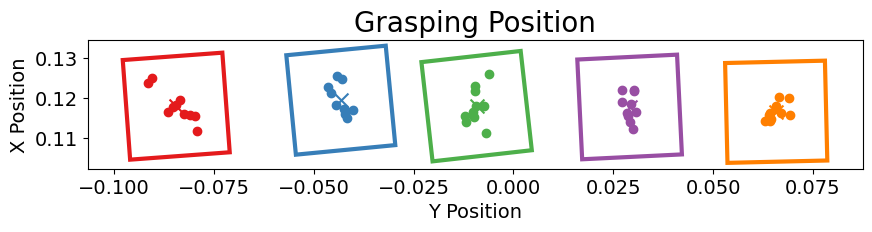

In [4]:

repo_id="nduque/robustness_e8_5"
repo_id="nduque/robustness_e8"

dataset = LeRobotDataset(repo_id)
observations = dataset.hf_dataset.select_columns("observation.state")['observation.state']
episodes = list(range(dataset.meta.total_episodes))
episode_data_index=get_episode_data_index(dataset.meta.episodes)

# Loop through dataset
#   Get observation (poses)
#   Save grasping position
#   Save observation, real action, predicted action in dictionary
obs_grasp = []
grasp_angle = []
for ep_idx in episodes:
    # Get the episode
    ep_start = int(episode_data_index["from"][ep_idx])
    ep_end = int(episode_data_index["to"][ep_idx])
    episode = dataset.hf_dataset

    obs_set = observations[ep_start+30:ep_end]
    if len(obs_set) == 0:
        continue        

    grasp_idx = next((i for i, obs in enumerate(obs_set) if obs[-1] < 30), None)

    if grasp_idx is None:
        grasp_idx = next((i for i, obs in enumerate(obs_set) if obs[-1] < 40), None)

    fk, yaw = forward_kinematics(obs_set[grasp_idx][-6:],d,a,alpha)
    obs_grasp.append(fk)
    grasp_angle.append(yaw)
obs_grasp = np.array(obs_grasp)

box_pos_avg_e8 = np.array([[ 0.1179,-0.0844, 4.2366],[ 0.1194, -0.0432, 5.4916],[ 0.1179, -0.0092, 6.4004],[ 0.1177, 0.0291, 2.7933],[ 0.1165, 0.0658, 1.3591]])
box_pos_avg_e8_5 = np.array([[0.1201, -0.076, 4.9085],[ 0.1199, -0.0373, 4.3924],[ 0.1198, -0.0012, 3.5846],[ 0.1211, 0.0374, 0.4634],[0.1217, 0.073, 0.0573]])

box_avg = box_pos_avg_e8

fig, axs = plt.subplots(1, 1, figsize=(10, 10))

eps = int(len(episodes)/len(box_avg))
d_xy = []
avg_ep = []
for i in range(len(box_avg)):
    color=colors[i]

    box_pos = box_avg[i]
        
    avg_y = float(round(np.mean(obs_grasp[i*eps:(i+1)*eps, 1]),4))
    avg_x = float(round(np.mean(obs_grasp[i*eps:(i+1)*eps, 0]),4))
    avg_yaw = float(round(np.mean(grasp_angle[i*eps:(i+1)*eps]),4))
    avg_ep.append([avg_x, avg_y, avg_yaw])
    print([avg_x, avg_y, avg_yaw])
    ep_dx = obs_grasp[i*eps:(i+1)*eps, 0] - box_avg[i,0]
    ep_dy = obs_grasp[i*eps:(i+1)*eps, 1] - box_avg[i,1]
    d_xy.append([ep_dx,ep_dy])

    fc = color
    axs.scatter(obs_grasp[i*eps:(i+1)*eps, 1], obs_grasp[i*eps:(i+1)*eps, 0],color=color, fc=fc)
    axs.scatter(avg_y, avg_x, color=color, marker='x', s=100)

    bottom_left = (box_pos[1]-0.0125,box_pos[0]-0.0125)
    rec = plt.Rectangle(bottom_left,0.025,0.025, ec=color, fc='none', angle = box_pos[2], rotation_point="center", linewidth=3)
    axs.add_patch(rec)

    #axs.text(box_pos_avg_e8[i,0],box_pos_avg_e8[i,1]-0.004,str(dist_to_avg),ha='center')
d_xy = np.array(d_xy)

axs.set_xlabel("Y Position", fontsize=14)
axs.set_ylabel("X Position", fontsize=14)
axs.set_title("Grasping Position", fontsize=20)
axs.set_aspect('equal')
#axs.set_ylim(0.08,0.15)
axs.tick_params(axis='both', which='major', labelsize=14)
#axs.set_xlim(-0.1,0.1)


### Evaluation plots ###

C:\Users\nduqu\AppData\Local\Temp\ipykernel_22320\3266642409.py:69: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  joint_angles_rad = np.radians(joint_angles)
C:\Users\nduqu\AppData\Local\Temp\ipykernel_22320\3266642409.py:76: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ct, st = np.cos(theta), np.sin(theta)


[0.1279, -0.0265, 4.1158]


[0.1278, -0.0135, 4.2024]


[0.1283, -0.0139, 3.9031]


[0.1288, -0.0184, 4.9077]


[0.1276, -0.0273, 4.665]


[0.127, -0.0144, 2.5423]


[0.1318, 0.0224, 3.7449]


[0.1265, -0.0383, 6.7132]
[0.1323, -0.0347, 4.3523]


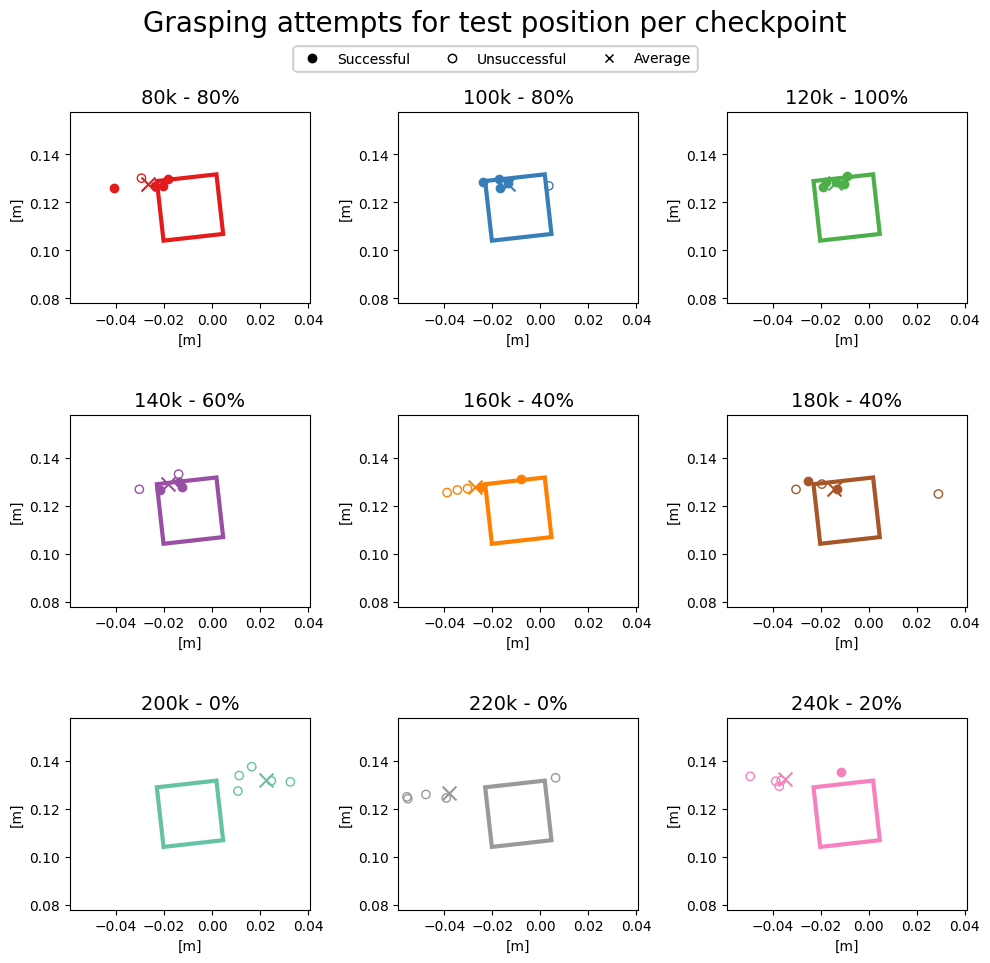

In [5]:
repos = ["nduque/eval_robustness_e8_no3_3_80k",
         "nduque/eval_robustness_e8_no3_3_100k_2",
         "nduque/eval_robustness_e8_no3_3_120k",
         "nduque/eval_robustness_e8_no3_3_140k",
         "nduque/eval_robustness_e8_no3_3_160k",
         "nduque/eval_robustness_e8_no3_3_180k",
         "nduque/eval_robustness_e8_no3_3_200k",
         "nduque/eval_robustness_e8_no3_3_220k",
         "nduque/eval_robustness_e8_no3_3_240k"]

success_3 = [[1,1,1,1,0],
           [0,1,1,1,1],
           [1,1,1,1,1],
           [0,0,1,1,1],
           [1,0,0,0,1],
           [0,1,1,0,0],
           [0,0,0,0,0],
           [0,0,0,0,0],
           [1,0,0,0,0]]

success_5 = [[0,0,0,0,0,0,0],
             [0,1,1,1,1],
             [1,1,1,1,1],
             [0,0,1,1,1],
             [1,0,0,0,1],
             [0,1,1,0,0],
             [0,0,0,0,0],
             [0,0,0,0,0],
             [1,0,0,0,0]]

titles = ["80k - 80%", "100k - 80%", "120k - 100%", "140k - 60%", "160k - 40%", "180k - 40%", "200k - 0%", "220k - 0%", "240k - 20%"]

avg_ep = []
fig, axs = plt.subplots(3,3, figsize=(10, 10))
d_xy = []
avg_err = []
total_grasp = []
for i,repo in enumerate(repos):
    

    dataset = LeRobotDataset(repo)
    observations = dataset.hf_dataset.select_columns("observation.state")['observation.state']
    episodes = list(range(dataset.meta.total_episodes))
    episode_data_index=get_episode_data_index(dataset.meta.episodes)
    eps_grasp = []
    eps_grasp_yaw = []

    box_avg = box_pos_avg_e8[2]
    eps = int(len(episodes)/len(box_avg))
    for j in range(len(episodes)):
        # Get the episode
        ep_start = int(episode_data_index["from"][episodes[j]])
        ep_end = int(episode_data_index["to"][episodes[j]])

        obs_set = observations[ep_start+30:ep_end]

        if len(obs_set) == 0:
            continue    
            
        grasp_idx = next((j for j, obs in enumerate(obs_set) if obs[-1] < 30), None)

        if grasp_idx is None:
            grasp_idx = next((j for j, obs in enumerate(obs_set) if obs[-1] < 40), None)

        fk, yaw = forward_kinematics(obs_set[grasp_idx][-6:],d,a,alpha)
        eps_grasp.append(fk)
        eps_grasp_yaw.append(yaw)

    cp_grasp = np.array(eps_grasp)
    cp_grasp_yaw = np.array(eps_grasp_yaw)
    total_grasp.append(cp_grasp[:5])

    color = colors[i]

    avg_y = float(round(np.mean(cp_grasp[:, 1]),4))
    avg_x = float(round(np.mean(cp_grasp[:, 0]),4))
    avg_yaw = float(round(np.mean(cp_grasp_yaw[:]),4))
    avg_ep.append([avg_x, avg_y, avg_yaw])
    print([avg_x, avg_y, avg_yaw]) 

    ep_dx = cp_grasp[:, 0] - box_avg[0]
    ep_dy = cp_grasp[:, 1] - box_avg[1]
    d_norm = np.sqrt(ep_dx**2 + ep_dy**2)
    d_xy.append([ep_dx,ep_dy,d_norm])

    avg_err_x = np.mean((ep_dx))
    avg_err_y = np.mean((ep_dy))
    avg_err_norm = np.mean(d_norm)
    avg_err.append([avg_err_x, avg_err_y, avg_err_norm])


    for j in range(5):
        if success[i][j] == 0:
            fc = 'none'
        else:
            fc = color
        axs[i//3, i%3].scatter(cp_grasp[j,1], cp_grasp[j, 0],color=color, fc=fc)
 
    axs[i//3, i%3].scatter(avg_y, avg_x, color=color, marker='x', s=100)

    bottom_left = (box_avg[1]-0.0125,box_avg[0]-0.0125)
    rec = plt.Rectangle(bottom_left,0.025,0.025, ec=color, fc='none', angle = box_avg[2], rotation_point="center", linewidth=3)
    axs[i//3, i%3].add_patch(rec)
    axs[i//3, i%3].set_aspect('equal')
    axs[i//3, i%3].set_ylim(box_avg[0]-0.04,box_avg[0]+0.04)
    axs[i//3, i%3].set_xlim(box_avg[1]-0.05,box_avg[1]+0.05)
    axs[i//3, i%3].set_title(titles[i], fontsize=14)
    axs[i//3, i%3].set_xlabel('[m]', fontsize=10) 
    axs[i//3, i%3].set_ylabel('[m]', fontsize=10) 

    success_marker = mlines.Line2D([], [], color='black', marker='o', markersize=6, label='Successful', fillstyle='full', linestyle='None')
    unsuccess_marker = mlines.Line2D([], [], color='black', marker='o', markersize=6, label='Unsuccessful', fillstyle='none', linestyle='None')
    average_marker = mlines.Line2D([], [], color='black', marker='x', markersize=6, label='Average', fillstyle='none', linestyle='None')
    fig.legend(handles=[success_marker, unsuccess_marker,average_marker], loc='upper center', bbox_to_anchor=(0.5,0.95), fontsize=10, ncol=3)
    fig.suptitle("Grasping attempts for test position per checkpoint", fontsize=20)
    fig.tight_layout()



C:\Users\nduqu\AppData\Local\Temp\ipykernel_22320\3278808443.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs2[idx].boxplot(boxplot_data, vert=True, labels=cps,positions = range(9))
C:\Users\nduqu\AppData\Local\Temp\ipykernel_22320\3278808443.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs2[idx].boxplot(boxplot_data, vert=True, labels=cps,positions = range(9))


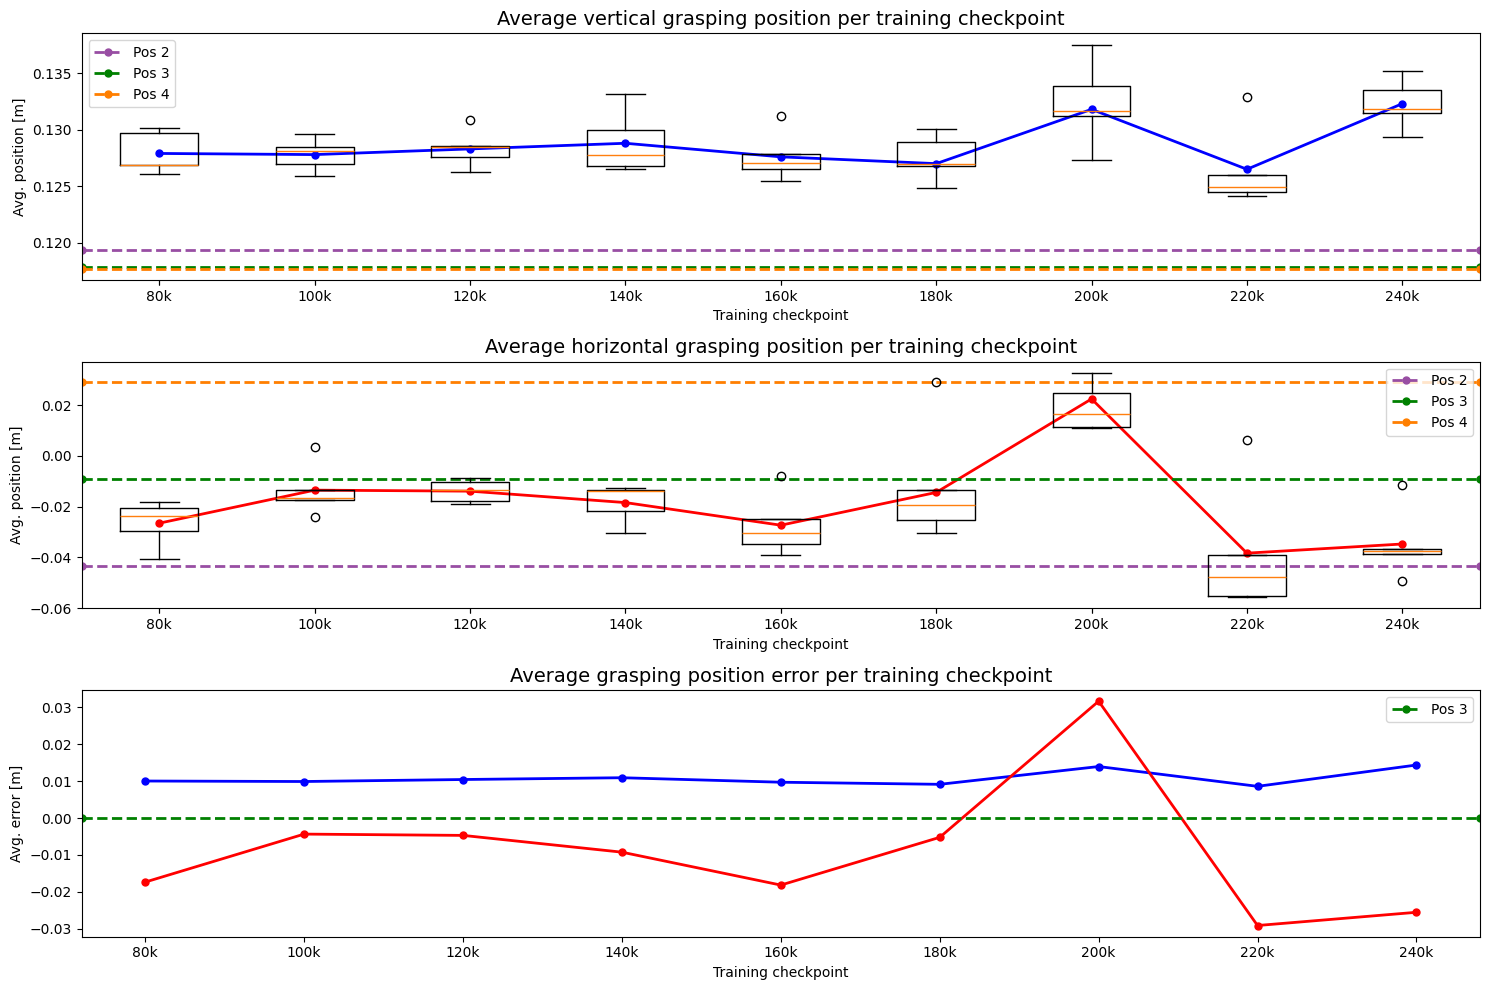

In [6]:
fig2, axs2 = plt.subplots(3, 1, figsize=(15, 10))
l_fs = 10
t_fs = 14

avg_ep = np.array(avg_ep)
avg_err = np.array(avg_err)
total_grasp = np.stack(total_grasp, axis=0)


cps = ['80k', '100k', '120k', '140k', '160k', '180k', '200k', '220k', '240k']

for idx, label in enumerate(['vertical', 'horizontal']):
    axs2[idx].plot(avg_ep[:, idx], color='blue' if idx == 0 else 'red', marker='o', linestyle='-', linewidth=2, markersize=5)
    axs2[idx].axhline(box_pos_avg_e8[1, idx], color=colors[3], marker='o', linestyle='--', linewidth=2, markersize=5, label='Pos 2')
    axs2[idx].axhline(box_avg[idx], color='green', marker='o', linestyle='--', linewidth=2, markersize=5, label='Pos 3')
    axs2[idx].axhline(box_pos_avg_e8[3, idx], color=colors[4], marker='o', linestyle='--', linewidth=2, markersize=5, label='Pos 4')
    axs2[idx].set_xticks(range(9), cps, fontsize=l_fs)
    axs2[idx].set_xlabel('Training checkpoint', fontsize=l_fs)
    axs2[idx].set_ylabel('Avg. position [m]', fontsize=l_fs)
    axs2[idx].set_title(f'Average {label} grasping position per training checkpoint', fontsize=t_fs)
    axs2[idx].legend(fontsize=l_fs)
    boxplot_data = [arr[:,idx] for arr in total_grasp]
    axs2[idx].boxplot(boxplot_data, vert=True, labels=cps,positions = range(9))

axs2[2].plot(avg_err[:,0], color='blue', marker='o', linestyle='-', linewidth=2, markersize=5)
axs2[2].plot(avg_err[:,1], color='red', marker='o', linestyle='-', linewidth=2, markersize=5)
axs2[2].axhline(0.0, color='green', marker='o', linestyle='--', linewidth=2, markersize=5, label='Pos 3')
axs2[2].set_xticks(range(9),cps, fontsize=l_fs)
axs2[2].set_xlabel('Training checkpoint', fontsize=l_fs)
axs2[2].set_ylabel('Avg. error [m]', fontsize=l_fs)
axs2[2].set_title('Average grasping position error per training checkpoint', fontsize=t_fs)
axs2[2].legend(fontsize=l_fs)


fig2.tight_layout()



Text(0.5, 1.0, 'Validation loss')

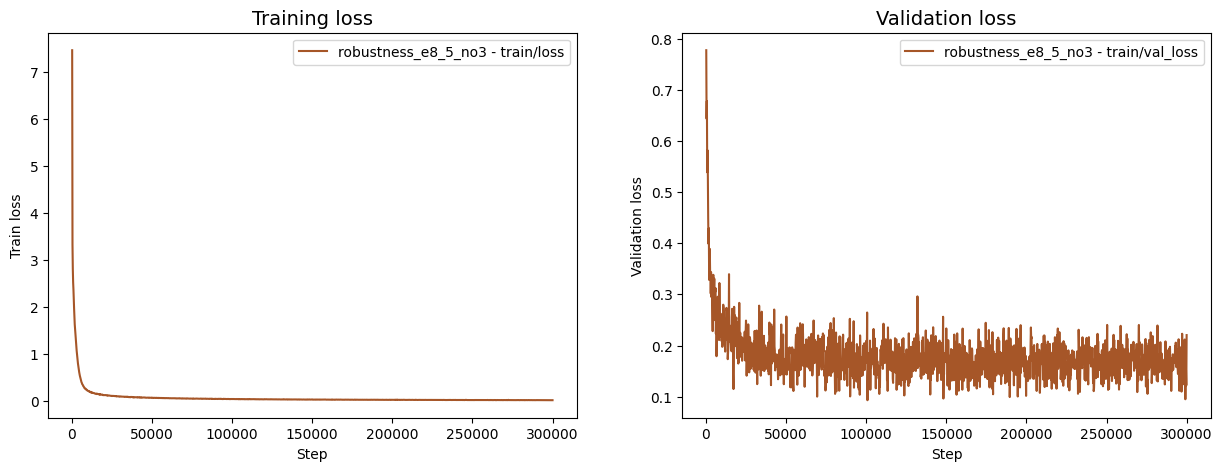

In [29]:
# Read the CSV file
csv_train = pd.read_csv('csv/e8_5_no3_dp_train_loss.csv')
csv_val = pd.read_csv('csv/e8_5_no3_dp_val_loss.csv')
fig3, axs3 = plt.subplots(1, 2, figsize=(15, 5))
# Plot the dataframe
csv_train.plot(ax=axs3[0],x='Step', y='robustness_e8_5_no3 - train/loss', color=colors[5])
csv_val.plot(ax=axs3[1],x='Step', y='robustness_e8_5_no3 - train/val_loss', color=colors[5])
axs3[0].set_ylabel('Train loss',fontsize=l_fs)
axs3[1].set_ylabel('Validation loss',fontsize=l_fs)
axs3[0].set_xlabel('Step', fontsize= l_fs)
axs3[1].set_xlabel('Step', fontsize=l_fs)
axs3[0].set_title('Training loss',fontsize=t_fs)
axs3[1].set_title('Validation loss',fontsize=t_fs)

## E9 Plots ##
### Dataset plot ###

C:\Users\nduqu\AppData\Local\Temp\ipykernel_9640\1492091376.py:70: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  joint_angles_rad = np.radians(joint_angles)
C:\Users\nduqu\AppData\Local\Temp\ipykernel_9640\1492091376.py:77: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ct, st = np.cos(theta), np.sin(theta)


[0.193, -0.0786, 5.8925]
[0.1898, -0.0009, 4.1929]
[0.1957, 0.0807, 1.2011]
[0.1533, -0.0393, 5.8473]
[0.1567, 0.0353, 1.4479]
[0.1211, -0.0746, 4.0604]
[0.1188, -0.0025, 3.8189]
[0.12, 0.0722, 0.7847]
[0.0861, -0.0396, 4.738]
[0.0868, 0.0366, -1.0705]
[0.0526, -0.0696, 4.0597]
[0.053, -0.0021, 1.3559]
[0.0554, 0.0694, -0.1613]


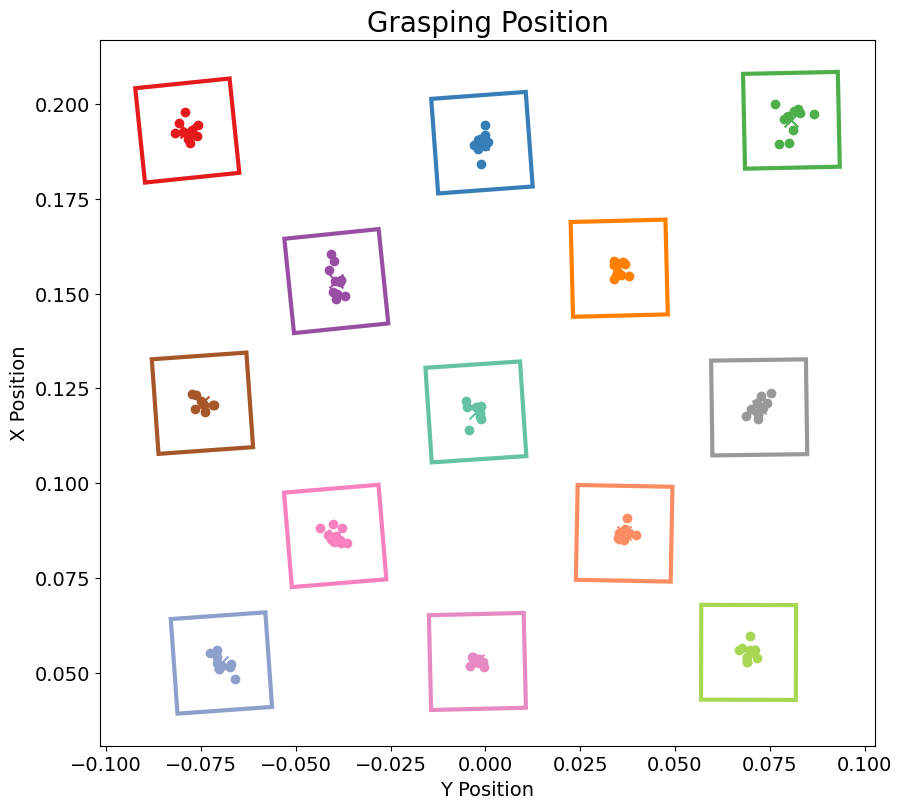

In [63]:

repo_id="nduque/robustness_e9_3"

dataset = LeRobotDataset(repo_id)
observations = dataset.hf_dataset.select_columns("observation.state")['observation.state']
episodes = list(range(dataset.meta.total_episodes))
episode_data_index=get_episode_data_index(dataset.meta.episodes)

# Loop through dataset
#   Get observation (poses)
#   Save grasping position
#   Save observation, real action, predicted action in dictionary
obs_grasp = []
grasp_angle = []
for ep_idx in episodes:
    # Get the episode
    ep_start = int(episode_data_index["from"][ep_idx])
    ep_end = int(episode_data_index["to"][ep_idx])
    episode = dataset.hf_dataset

    obs_set = observations[ep_start+30:ep_end]
    if len(obs_set) == 0:
        continue        

    grasp_idx = next((i for i, obs in enumerate(obs_set) if obs[-1] < 30), None)

    if grasp_idx is None:
        grasp_idx = next((i for i, obs in enumerate(obs_set) if obs[-1] < 40), None)

    fk, yaw = forward_kinematics(obs_set[grasp_idx][-6:],d,a,alpha)
    obs_grasp.append(fk)
    grasp_angle.append(yaw)
    
obs_grasp = np.array(obs_grasp)

box_pos_avg_e9_3 = np.array([[0.193, -0.0786,  5.8925],[ 0.1898,-0.0009, 4.1929],[ 0.1957,0.0807, 1.2011],
                                 [ 0.1533,-0.0393, 5.8473],[ 0.1567,0.0353, 1.4479],[ 0.1211,-0.0746, 4.0604],
                                 [ 0.1188,-0.0025, 3.8189],[ 0.12,0.0722, 0.7847],[ 0.0861,-0.0396, 4.738],
                                 [ 0.0868,0.0366, -1.0705],[ 0.0526,-0.0696, 4.0597],[ 0.053,-0.0021, 1.3559],[ 0.0554,0.0694, -0.1613]])

box_avg = box_pos_avg_e9_3

fig, axs = plt.subplots(1, 1, figsize=(10, 10))

eps = int(len(episodes)/len(box_avg))
d_xy = []
avg_ep = []
for i in range(len(box_avg)):
    color=colors[i]

    box_pos = box_avg[i]
        
    avg_y = float(round(np.mean(obs_grasp[i*eps:(i+1)*eps, 1]),4))
    avg_x = float(round(np.mean(obs_grasp[i*eps:(i+1)*eps, 0]),4))
    avg_yaw = float(round(np.mean(grasp_angle[i*eps:(i+1)*eps]),4))
    avg_ep.append([avg_x, avg_y, avg_yaw])
    print([avg_x, avg_y, avg_yaw])
    ep_dx = obs_grasp[i*eps:(i+1)*eps, 0] - box_avg[i,0]
    ep_dy = obs_grasp[i*eps:(i+1)*eps, 1] - box_avg[i,1]
    d_xy.append([ep_dx,ep_dy])

    fc = color
    axs.scatter(obs_grasp[i*eps:(i+1)*eps, 1], obs_grasp[i*eps:(i+1)*eps, 0],color=color, fc=fc)
    axs.scatter(avg_y, avg_x, color=color, marker='x', s=100)

    bottom_left = (box_pos[1]-0.0125,box_pos[0]-0.0125)
    rec = plt.Rectangle(bottom_left,0.025,0.025, ec=color, fc='none', angle = box_pos[2], rotation_point="center", linewidth=3)
    axs.add_patch(rec)

    #axs.text(box_pos_avg_e8[i,0],box_pos_avg_e8[i,1]-0.004,str(dist_to_avg),ha='center')
d_xy = np.array(d_xy)

axs.set_xlabel("Y Position", fontsize=14)
axs.set_ylabel("X Position", fontsize=14)
axs.set_title("Grasping Position", fontsize=20)
axs.set_aspect('equal')
#axs.set_ylim(0.08,0.15)
axs.tick_params(axis='both', which='major', labelsize=14)
#axs.set_xlim(-0.1,0.1)

### Evaluation plots ###
#### Grasping plot + success rate heatmap full_dp_cluster_200k ####


C:\Users\nduqu\AppData\Local\Temp\ipykernel_9640\1492091376.py:70: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  joint_angles_rad = np.radians(joint_angles)
C:\Users\nduqu\AppData\Local\Temp\ipykernel_9640\1492091376.py:77: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ct, st = np.cos(theta), np.sin(theta)


[[np.float64(0.0013415129503237294), np.float64(0.0010769777079376636), np.float64(0.0021873804586767347)], [np.float64(-0.006324496975397336), np.float64(-0.017070294074122968), np.float64(0.020618324095011884)], [np.float64(-0.0038323758980534322), np.float64(-0.0035721547034344298), np.float64(0.006455441313164405)], [np.float64(-0.010052222781236483), np.float64(-0.009219514926667952), np.float64(0.017416248556905174)], [np.float64(0.0006434169464640102), np.float64(0.0006996361890790218), np.float64(0.0038648531205529558)], [np.float64(0.008158456751097156), np.float64(0.01990502642792235), np.float64(0.021773688831847254)], [np.float64(0.0040075764270127755), np.float64(-0.0012942231550558175), np.float64(0.005250128417174055)], [np.float64(0.000843166927444909), np.float64(-0.0019238407936499682), np.float64(0.0039511956646983435)], [np.float64(-0.0017424595317062641), np.float64(6.063438540010209e-05), np.float64(0.004449465035172825)], [np.float64(0.0078667019840201), np.float

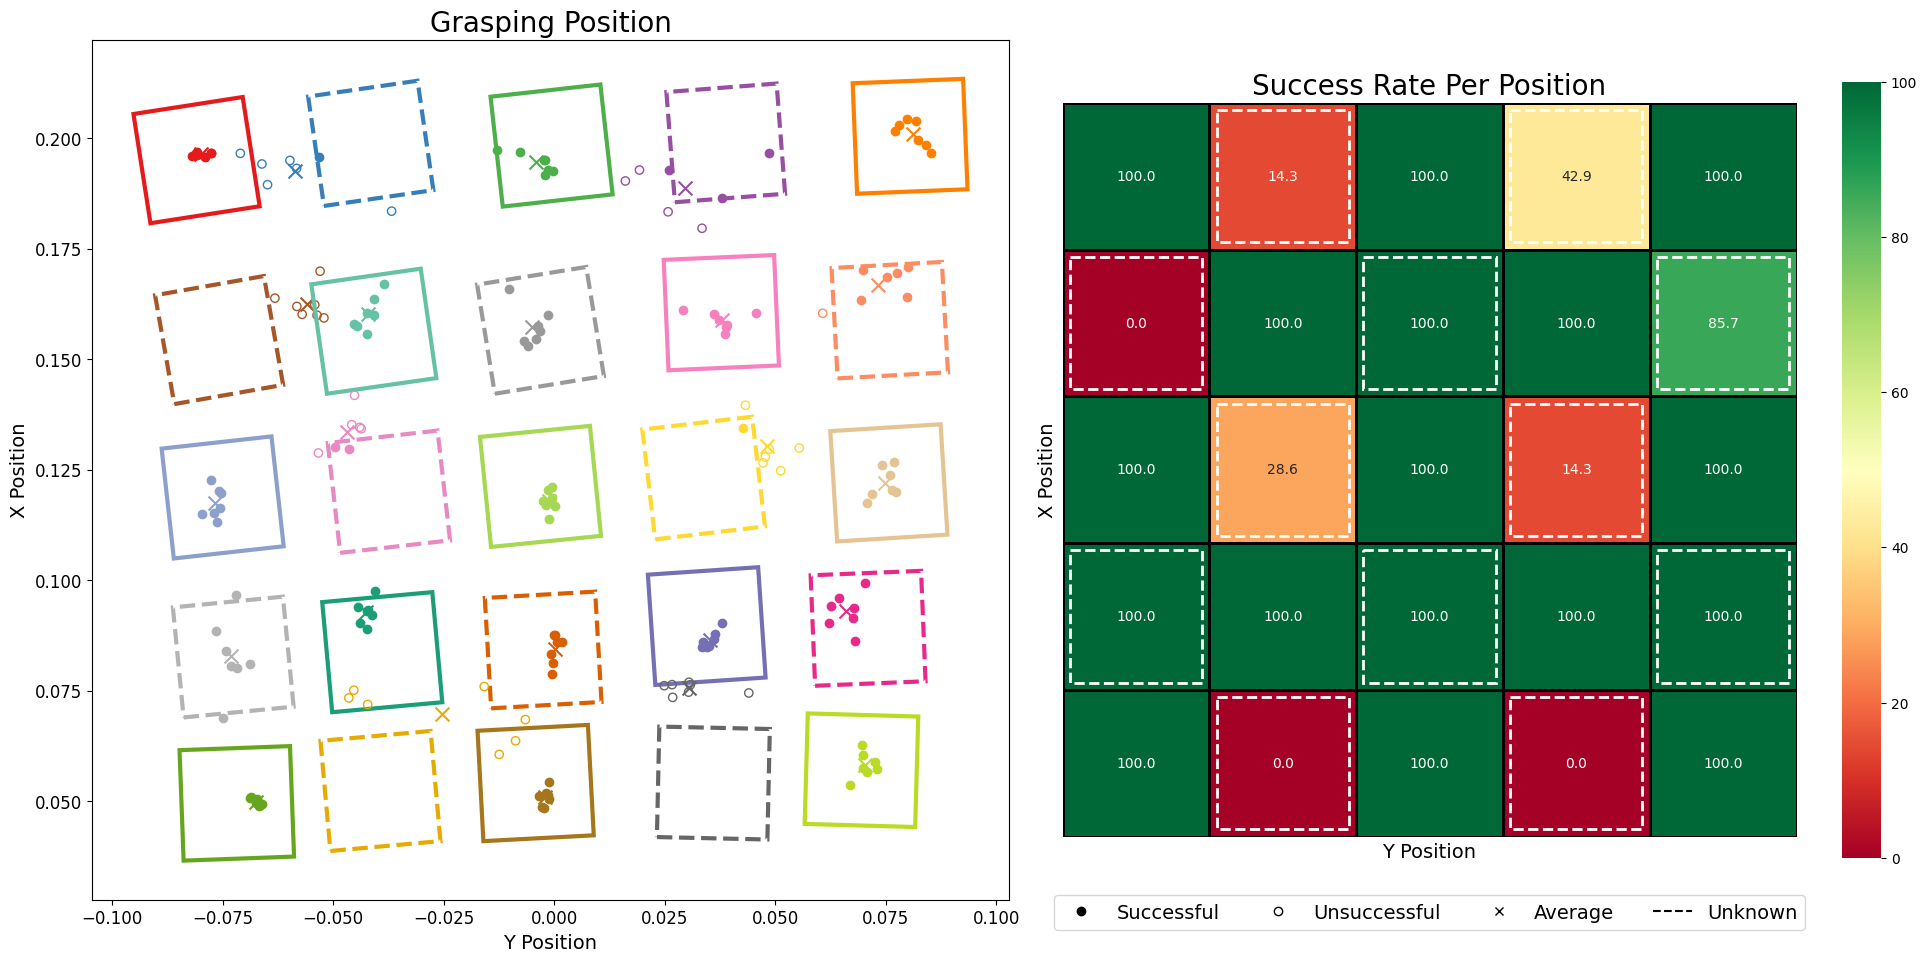

In [64]:
repo_id="nduque/eval_robustness_e9_3_full_dp_cluster_200k"
known_mask = np.array([
    [True, False, True, False, True],
    [False, True, False, True, False],
    [True, False, True, False, True],
    [False, True, False, True, False],
    [True, False, True, False, True],
])
box_pos_avg_e9_all = [[0.195,-0.0809,  8.8293],[0.1988,-0.0415,  8.2231],[ 0.1983,-0.0006, 6.3474],[ 0.1989, 0.0388, 4.407],[ 0.2004,0.0805, 2.3005],
                   [ 0.1543,-0.0758, 10.03],[ 0.1563,-0.0408, 8.1177],[ 0.1565,-0.0031, 9.1966],[ 0.1605,0.0378, 2.4887],[ 0.1588, 0.0759,3.1575],
                   [ 0.1187,-0.075, 6.3325],[ 0.12,-0.0374, 6.469],[ 0.1212,-0.0031, 5.7372],[ 0.1231,0.0338, 6.6873],[ 0.122,0.0757, 3.5465],
                   [ 0.0826,-0.0726, 5.5792],[ 0.0837,-0.0389, 5.1754],[ 0.0842,-0.0025, 3.2955],[ 0.0896,0.0345, 3.8578],[ 0.0891,0.071, 2.3324],
                   [ 0.0495,-0.0718, 2.1085],[ 0.0523,-0.0393, 5.1431],[0.0541,-0.0042,  3.0332],[ 0.0541,0.036, -1.2648],[ 0.057,0.0695, -1.611]]

success_e9_3_full_dp_cluster_200k = np.array([1,1,1,1,1,1,1, #1
                                                0,0,0,0,0,0,1, #2
                                                1,1,1,1,1,1,1, #3
                                                1,1,0,0,0,1,0, #4 --changed success of 25 (5th), because it didnt pick in first attempt
                                                1,1,1,1,1,1,1, #5
                                                0,0,0,0,0,0,0, #6
                                                1,1,1,1,1,1,1, #7
                                                1,1,1,1,1,1,1, #8
                                                1,1,1,1,1,1,1, #9
                                                1,0,1,1,1,1,1, #10
                                                1,1,1,1,1,1,1, #11
                                                1,0,0,1,0,0,0, #12 
                                                1,1,1,1,1,1,1, #13 
                                                0,0,0,0,0,0,1, #14
                                                1,1,1,1,1,1,1, #15
                                                1,1,1,1,1,1,1, #16
                                                1,1,1,1,1,1,1, #17
                                                1,1,1,1,1,1,1, #18
                                                1,1,1,1,1,1,1, #19
                                                1,1,1,1,1,1,1, #20
                                                1,1,1,1,1,1,1, #21
                                                0,0,0,0,0,0,0, #22
                                                1,1,1,1,1,1,1, #23
                                                0,0,0,0,0,0,0, #24
                                                1,1,1,1,1,1,1  #25
                                                ]) 
dataset = LeRobotDataset(repo_id)
observations = dataset.hf_dataset.select_columns("observation.state")['observation.state']
episodes = list(range(dataset.meta.total_episodes))
episode_data_index=get_episode_data_index(dataset.meta.episodes)

# Loop through dataset
#   Get observation (poses)
#   Save grasping position
#   Save observation, real action, predicted action in dictionary
obs_grasp = []
grasp_angle = []
total_grasp = []
for ep_idx in episodes:
    # Get the episode
    ep_start = int(episode_data_index["from"][ep_idx])
    ep_end = int(episode_data_index["to"][ep_idx])

    obs_set = observations[ep_start+30:ep_end]

    if len(obs_set) == 0:
        continue        

    grasp_idx = next((i for i, obs in enumerate(obs_set) if obs[-1] < 30), None)

    if grasp_idx is None:
        grasp_idx = next((i for i, obs in enumerate(obs_set) if obs[-1] < 40), None)

    fk, yaw = forward_kinematics(obs_set[grasp_idx][-6:],d,a,alpha)
    obs_grasp.append(fk)
    grasp_angle.append(yaw)


obs_grasp = np.array(obs_grasp)


fig, axs = plt.subplots(1, 2, figsize=(20, 10))

box_pos_avg_e9_all = np.array(box_pos_avg_e9_all)
box_avg = box_pos_avg_e9_all
eps = int(len(episodes)/len(box_avg))

success = success_e9_3_full_dp_cluster_200k
success_accum = np.sum(success.reshape(25,7), axis=1)/7 * 100
eps = int(len(episodes)/len(box_avg))
d_xy = []
avg_ep = []
avg_err = []

for i in range(len(box_avg)):
    color=colors[i]

    box_pos = box_avg[i]
        
    avg_y = float(round(np.mean(obs_grasp[i*eps:(i+1)*eps, 1]),4))
    avg_x = float(round(np.mean(obs_grasp[i*eps:(i+1)*eps, 0]),4))
    avg_yaw = float(round(np.mean(grasp_angle[i*eps:(i+1)*eps]),4))
    avg_ep.append([avg_x, avg_y, avg_yaw])

    ep_dx = obs_grasp[i*eps:(i+1)*eps, 0] - box_avg[i,0]
    ep_dy = obs_grasp[i*eps:(i+1)*eps, 1] - box_avg[i,1]
    d_norm = np.sqrt(ep_dx**2 + ep_dy**2)
    d_xy.append([ep_dx,ep_dy,d_norm])

    avg_err_x = np.mean((ep_dx))
    avg_err_y = np.mean((ep_dy))
    avg_err_norm = np.mean(d_norm)
    avg_err.append([avg_err_x, avg_err_y, avg_err_norm])

    total_grasp.append(obs_grasp[i*eps:(i+1)*eps])

    fc = color
    for j in range(eps):
            if success[i*eps+j] == 0:
                fc = 'none'
            else:
                fc = color
            axs[0].scatter(obs_grasp[i*eps+j,1], obs_grasp[i*eps+j, 0],color=color, fc=fc)
    axs[0].scatter(avg_y, avg_x, color=color, marker='x', s=100)

    bottom_left = (box_pos[1]-0.0125,box_pos[0]-0.0125)
    if known_mask[i//5, i%5]:
        rec = plt.Rectangle(bottom_left,0.025,0.025, ec=color, fc='none', angle = box_pos[2], rotation_point="center", linewidth=3)
    else:
        rec = plt.Rectangle(bottom_left,0.025,0.025, ec=color, fc='none', angle = box_pos[2], rotation_point="center", linewidth=3, linestyle='--')
    axs[0].add_patch(rec)


d_xy = np.array(d_xy)

axs[0].set_xlabel("Y Position", fontsize=14)
axs[0].set_ylabel("X Position", fontsize=14)
axs[0].tick_params(labelsize=12)
axs[0].set_title("Grasping Position", fontsize=20)
axs[0].set_aspect('equal')
#axs.set_ylim(0.04,0.22)
#axs.set_xlim(-0.1,0.1)

print(avg_err)


success_accum = success_accum.reshape(5, 5)
annot_format=".1f"


axs[1] = sns.heatmap(success_accum, annot=True, fmt=annot_format, cmap="RdYlGn", cbar=True, linewidths=1,linecolor='black',vmin=0,vmax=100,square=True,cbar_kws={"shrink": 0.8})

if known_mask is not None:
        for y in range(success_accum.shape[0]):
            for x in range(success_accum.shape[1]):
                if not known_mask[y, x]:
                    axs[1].add_patch(plt.Rectangle((x+0.05, y+0.05), 0.9, 0.9,fill=False, edgecolor='white',linestyle='--',lw=2))

axs[1].set_xlabel("Y Position", fontsize=14)
axs[1].set_ylabel("X Position", fontsize=14)
axs[1].set_title("Success Rate Per Position", fontsize=20)
axs[1].set_xticks([])
axs[1].set_yticks([])

success_marker = mlines.Line2D([], [], color='black', marker='o', markersize=6, label='Successful', fillstyle='full', linestyle='None')
unsuccess_marker = mlines.Line2D([], [], color='black', marker='o', markersize=6, label='Unsuccessful', fillstyle='none', linestyle='None')
average_marker = mlines.Line2D([], [], color='black', marker='x', markersize=6, label='Average', fillstyle='none', linestyle='None')
unknown_marker = mlines.Line2D([], [], color='black', marker='None', markersize=6, label='Unknown', fillstyle='none', linestyle='--')
fig.legend(handles=[success_marker, unsuccess_marker,average_marker, unknown_marker], loc='lower right', bbox_to_anchor=(0.91,0.03), fontsize=14, ncol=4)
#fig.suptitle("Grasping attempts for test position", fontsize=20)
fig.tight_layout()

#### Line plot of avg x,y for each position ####

(25, 7, 3)


C:\Users\nduqu\AppData\Local\Temp\ipykernel_9640\2557844179.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs2[idx].legend(fontsize=l_fs)
C:\Users\nduqu\AppData\Local\Temp\ipykernel_9640\2557844179.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs2[idx].legend(fontsize=l_fs)


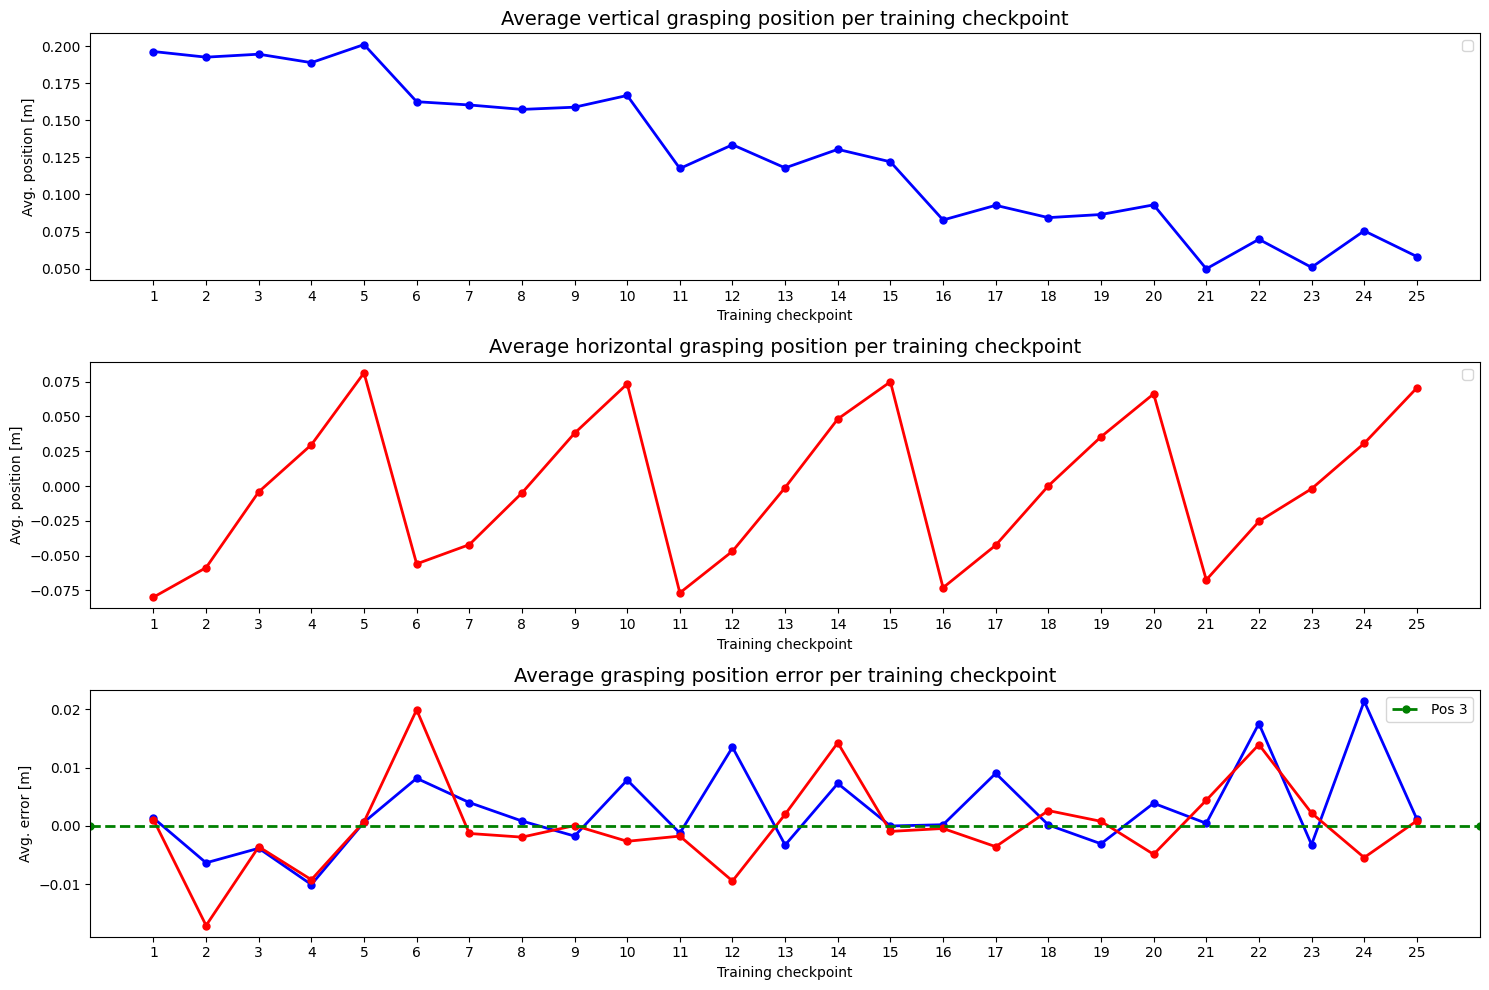

In [4]:
fig2, axs2 = plt.subplots(3, 1, figsize=(15, 10))
l_fs = 10
t_fs = 14

avg_ep = np.array(avg_ep)
avg_err = np.array(avg_err)

total_grasp = np.stack(total_grasp, axis=0)
print(total_grasp.shape)

pos = range(1, 26)

for idx, label in enumerate(['vertical', 'horizontal']):
    axs2[idx].plot(avg_ep[:, idx], color='blue' if idx == 0 else 'red', marker='o', linestyle='-', linewidth=2, markersize=5)
    #axs2[idx].axhline(box_pos_avg_e8[1, idx], color=colors[3], marker='o', linestyle='--', linewidth=2, markersize=5, label='Pos 2')
    #axs2[idx].axhline(box_avg[idx], color='green', marker='o', linestyle='--', linewidth=2, markersize=5, label='Pos 3')
    #axs2[idx].axhline(box_pos_avg_e8[3, idx], color=colors[4], marker='o', linestyle='--', linewidth=2, markersize=5, label='Pos 4')
    axs2[idx].set_xticks(range(25), pos, fontsize=l_fs)
    axs2[idx].set_xlabel('Training checkpoint', fontsize=l_fs)
    axs2[idx].set_ylabel('Avg. position [m]', fontsize=l_fs)
    axs2[idx].set_title(f'Average {label} grasping position per training checkpoint', fontsize=t_fs)
    axs2[idx].legend(fontsize=l_fs)
    boxplot_data = [arr[:,idx] for arr in total_grasp]
    #axs2[idx].boxplot(boxplot_data, vert=True, labels=pos,positions = range(25))

axs2[2].plot(avg_err[:,0], color='blue', marker='o', linestyle='-', linewidth=2, markersize=5)
axs2[2].plot(avg_err[:,1], color='red', marker='o', linestyle='-', linewidth=2, markersize=5)
axs2[2].axhline(0.0, color='green', marker='o', linestyle='--', linewidth=2, markersize=5, label='Pos 3')
axs2[2].set_xticks(range(25),pos, fontsize=l_fs)
axs2[2].set_xlabel('Training checkpoint', fontsize=l_fs)
axs2[2].set_ylabel('Avg. error [m]', fontsize=l_fs)
axs2[2].set_title('Average grasping position error per training checkpoint', fontsize=t_fs)
axs2[2].legend(fontsize=l_fs)


fig2.tight_layout()


#### Error histogram ####

(-0.025, 0.025)

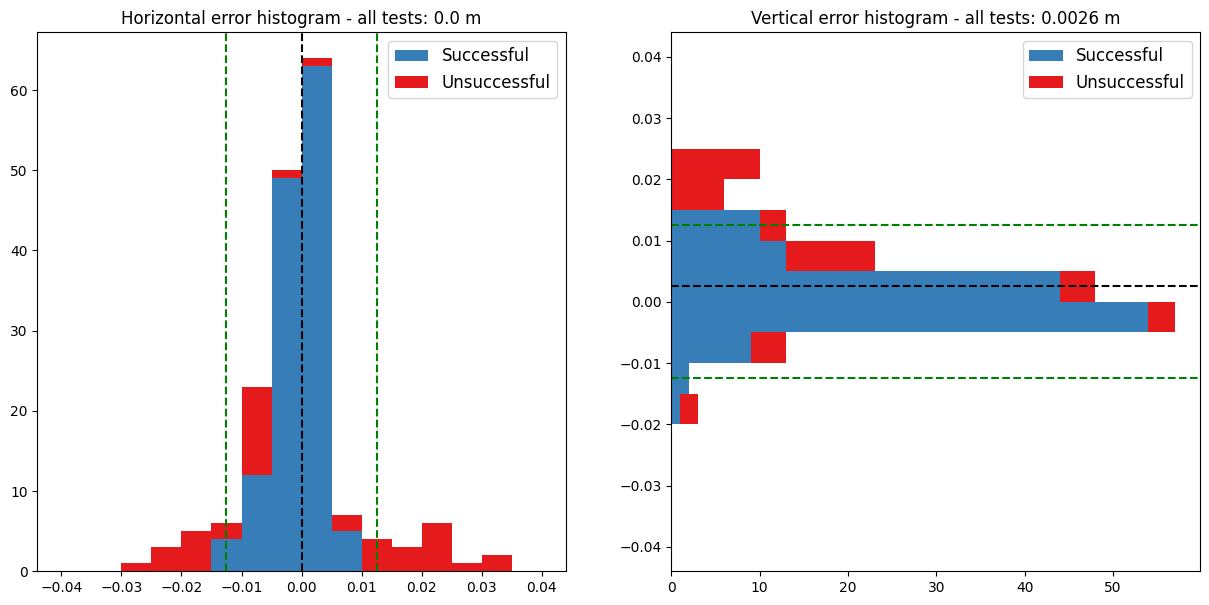

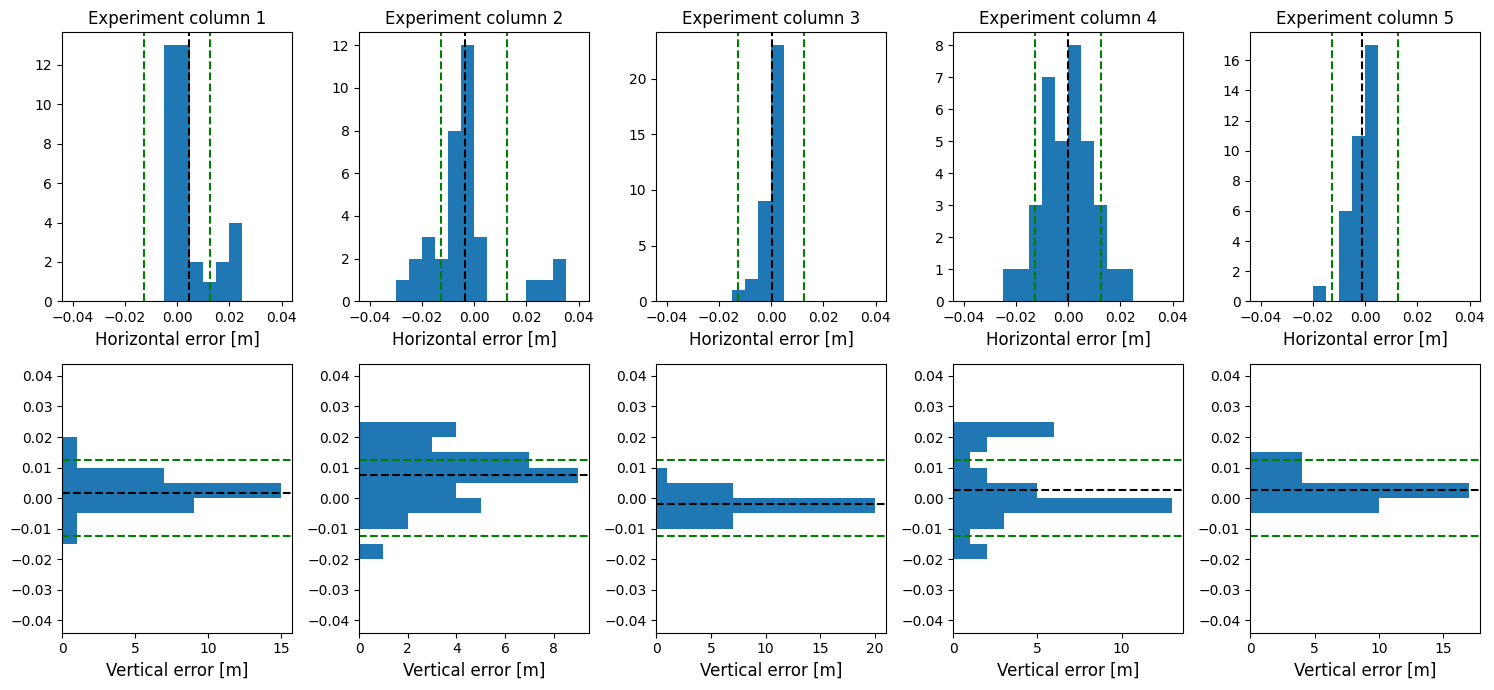

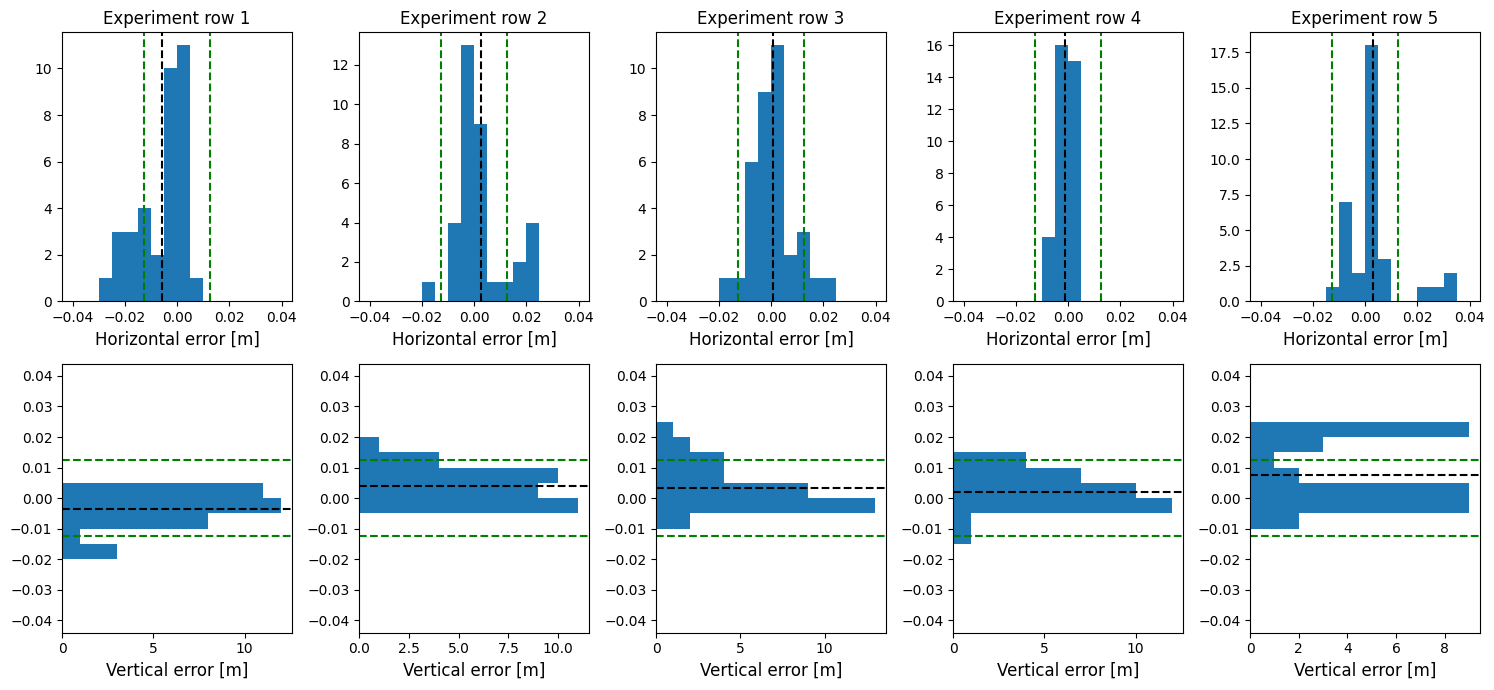

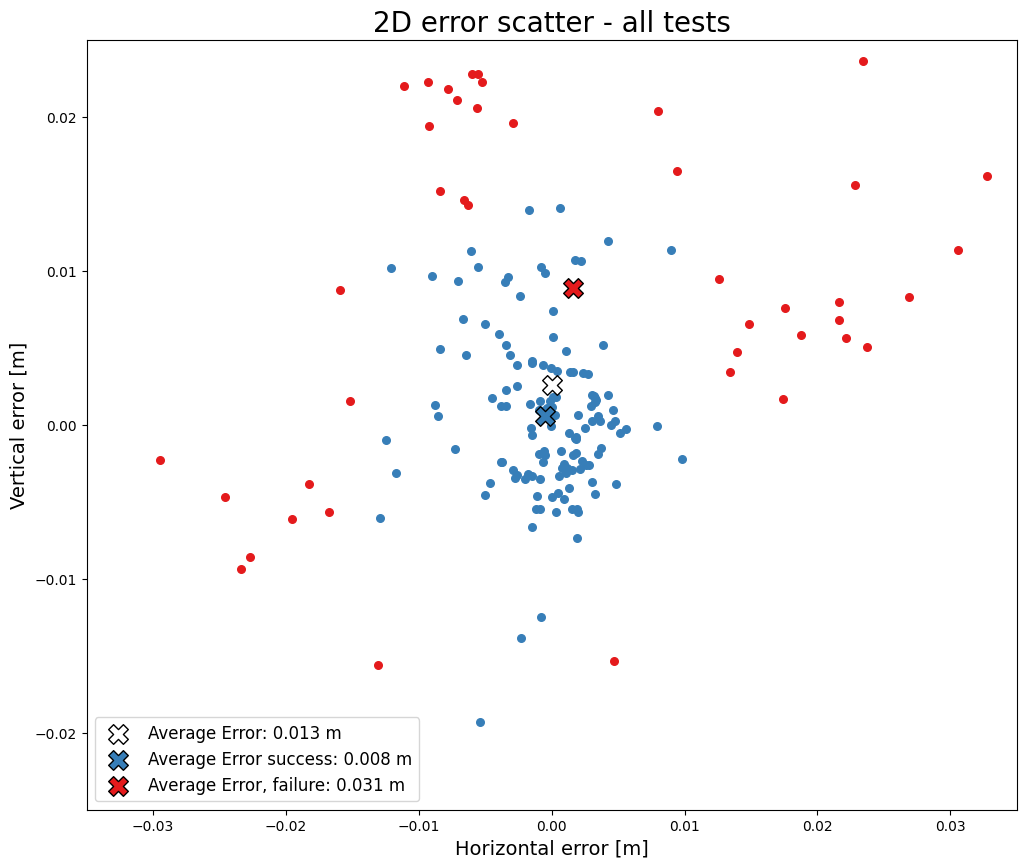

In [46]:
# Define bin width
bin_width = 0.005
########## GENERAL ERROR ANALYSIS ##########
bins = np.arange(-0.04, 0.04+bin_width, bin_width)

d_xy_reshape = d_xy.transpose(0,2,1).reshape(-1,3)
avg_err_x = np.mean(d_xy_reshape[:, 1])
avg_err_y = np.mean(d_xy_reshape[:, 0])
avg_err = round(np.mean(np.linalg.norm(d_xy_reshape, axis=1)),3)

avg_err_x_success = np.mean(d_xy_reshape[success == 1, 1])
avg_err_y_success = np.mean(d_xy_reshape[success == 1, 0])
avg_err_success = round(np.mean(np.linalg.norm(d_xy_reshape[success == 1], axis=1)),3)

avg_err_x_failed = np.mean(d_xy_reshape[success == 0, 1])
avg_err_y_failed = np.mean(d_xy_reshape[success == 0, 0]) 
avg_err_failed = round(np.mean(np.linalg.norm(d_xy_reshape[success == 0], axis=1)),3)

fig_gea, axs_gea = plt.subplots(1,2, figsize=(15, 7))

#axs8[0].hist(d_k_uk_x, bins=bins, label=['Known', 'Unknown'], stacked=False, color=colors[6:8])

axs_gea[0].hist([d_xy[:,1,:].flatten()[success == 1],d_xy[:,1,:].flatten()[success == 0]],label=['Successful','Unsuccessful'], color=[colors[1], colors[0]], stacked = True, bins=bins)
axs_gea[0].set_title("Horizontal error histogram - all tests: " + str(round(avg_err_x,4)) + " m")
axs_gea[0].axvline(0.0125, color='green', linestyle='--')
axs_gea[0].axvline(-0.0125, color='green', linestyle='--')
axs_gea[0].axvline(avg_err_x, color='black', linestyle='--')
axs_gea[0].legend(fontsize=12)

axs_gea[1].hist([d_xy[:,0,:].flatten()[success == 1],d_xy[:,0,:].flatten()[success == 0]], orientation='horizontal',label=['Successful','Unsuccessful'], color=[colors[1], colors[0]], stacked = True, bins=bins)
axs_gea[1].set_title("Vertical error histogram - all tests: " + str(round(avg_err_y,4)) + " m")
axs_gea[1].axhline(0.0125, color='green', linestyle='--')
axs_gea[1].axhline(-0.0125, color='green', linestyle='--')
axs_gea[1].axhline(avg_err_y, color='black', linestyle='--')
axs_gea[1].legend(fontsize=12)

#### COLUMNS ####
fig_gea_col, axs_gea_col = plt.subplots(2,5, figsize=(15, 7))


for i in range(5):
    axs_gea_col[0,i].set_title("Experiment column " + str(i+1))
    axs_gea_col[0,i].set_xlabel("Horizontal error [m]", fontsize=12)
    axs_gea_col[1,i].set_xlabel("Vertical error [m]", fontsize=12)
    axs_gea_col[0,i].tick_params(labelsize=10)
    axs_gea_col[1,i].tick_params(labelsize=10)
    axs_gea_col[0,i].hist(d_xy[i::5,1,:].flatten(), bins=bins)
    axs_gea_col[1,i].hist(d_xy[i::5,0,:].flatten(), bins=bins, orientation='horizontal')

    avg_err_x_gea_col = np.mean(d_xy[i::5,1,:].flatten())
    avg_err_y_gea_col = np.mean(d_xy[i::5,0,:].flatten())
    
    axs_gea_col[0,i].axvline(0.0125, color='green', linestyle='--')
    axs_gea_col[0,i].axvline(-0.0125, color='green', linestyle='--')
    axs_gea_col[0,i].axvline(avg_err_x_gea_col, color='black', linestyle='--')

    axs_gea_col[1,i].axhline(0.0125, color='green', linestyle='--')
    axs_gea_col[1,i].axhline(-0.0125, color='green', linestyle='--')
    axs_gea_col[1,i].axhline(avg_err_y_gea_col, color='black', linestyle='--')

fig_gea_col.tight_layout()

##### ROWS #####
fig_gea_row, axs_gea_row = plt.subplots(2,5, figsize=(15, 7))

for i in range(5):
    axs_gea_row[0,i].set_title("Experiment row " + str(i+1))
    axs_gea_row[0,i].set_xlabel("Horizontal error [m]", fontsize=12)
    axs_gea_row[1,i].set_xlabel("Vertical error [m]", fontsize=12)
    axs_gea_row[0,i].tick_params(labelsize=10)
    axs_gea_row[1,i].tick_params(labelsize=10)
    axs_gea_row[0,i].hist(d_xy[i*5:(i+1)*5,1,:].flatten(), bins=bins)
    axs_gea_row[1,i].hist(d_xy[i*5:(i+1)*5,0,:].flatten(), bins=bins, orientation='horizontal')

    avg_err_x_gea_row = np.mean(d_xy[i*5:(i+1)*5,1,:].flatten())
    avg_err_y_gea_row = np.mean(d_xy[i*5:(i+1)*5,0,:].flatten())
    
    axs_gea_row[0,i].axvline(0.0125, color='green', linestyle='--')
    axs_gea_row[0,i].axvline(-0.0125, color='green', linestyle='--')
    axs_gea_row[0,i].axvline(avg_err_x_gea_row, color='black', linestyle='--')

    axs_gea_row[1,i].axhline(0.0125, color='green', linestyle='--')
    axs_gea_row[1,i].axhline(-0.0125, color='green', linestyle='--')
    axs_gea_row[1,i].axhline(avg_err_y_gea_row, color='black', linestyle='--')

fig_gea_row.tight_layout()

fig_gea_scatter, axs_gea_scatter = plt.subplots(1, 1, figsize=(12, 10))
axs_gea_scatter.scatter(d_xy_reshape[success == 0,1], d_xy_reshape[success == 0,0], color=colors[0], s = 30)
axs_gea_scatter.scatter(d_xy_reshape[success == 1,1], d_xy_reshape[success ==1,0], color=colors[1], s = 30)
axs_gea_scatter.scatter(avg_err_x, avg_err_y, marker='X', s=200, color='white', edgecolors= 'black', label='Average Error: '+str(avg_err) + ' m')

axs_gea_scatter.scatter(avg_err_x_success, avg_err_y_success, marker='X', s=200, color=colors[1], edgecolors= 'black' ,label='Average Error success: '+str(avg_err_success) + ' m')
axs_gea_scatter.scatter(avg_err_x_failed, avg_err_y_failed, marker='X', s=200, color=colors[0], edgecolors= 'black', label='Average Error, failure: '+str(avg_err_failed) + ' m')

axs_gea_scatter.legend(fontsize = 12)
axs_gea_scatter.set_title("2D error scatter - all tests",fontsize=20)
axs_gea_scatter.set_xlabel("Horizontal error [m]", fontsize=14)
axs_gea_scatter.set_ylabel("Vertical error [m]", fontsize=14)

axs_gea_scatter.set_xlim(-0.035, 0.035)
axs_gea_scatter.set_ylim(-0.025, 0.025)





(175, 3)
93
149
52
77


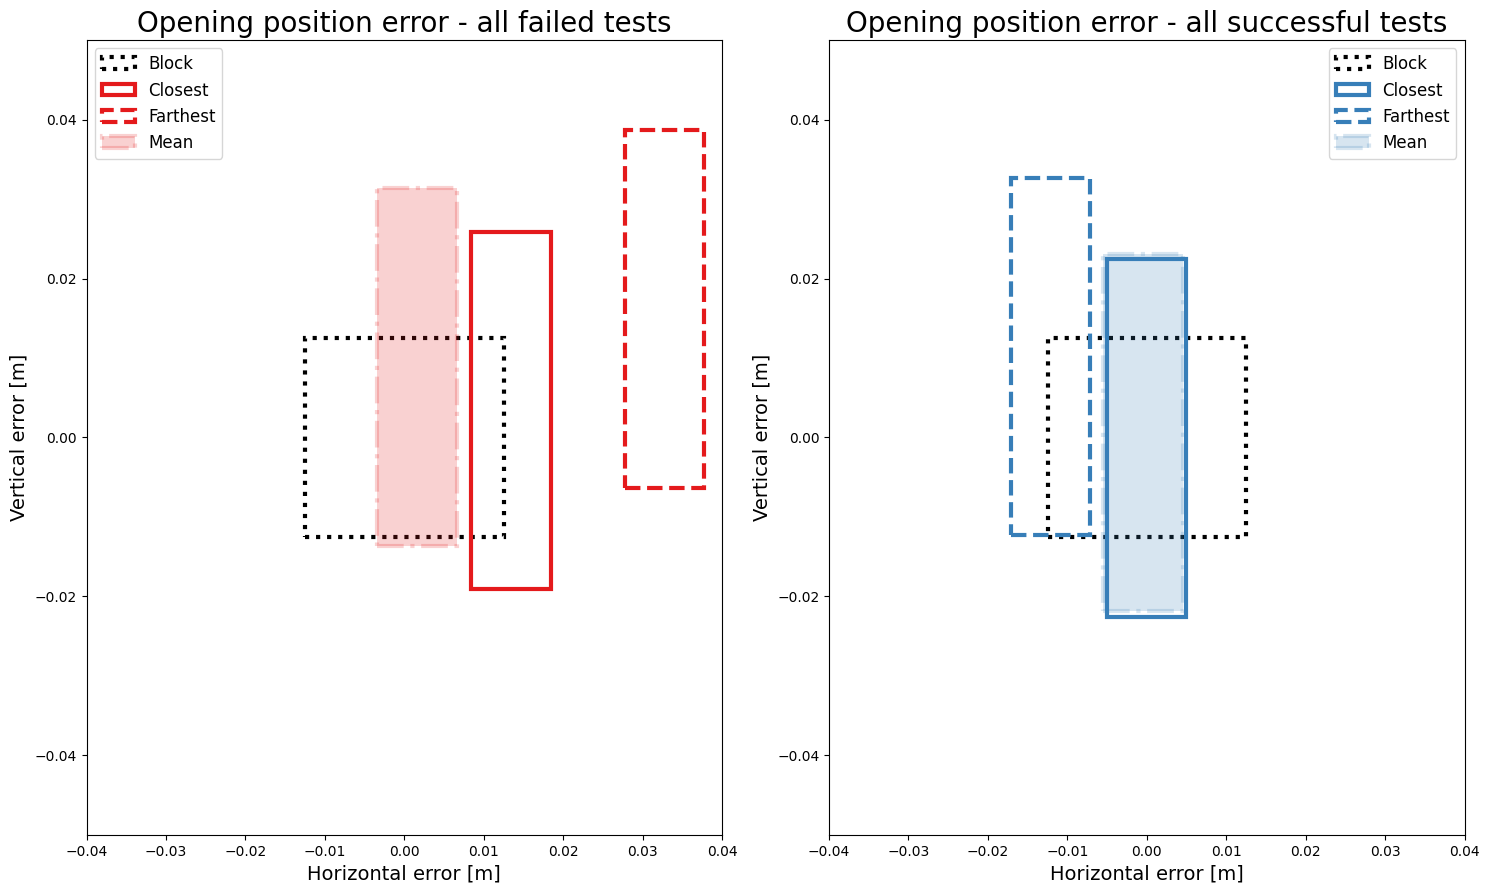

In [54]:
fig_gea_opening, axs_gea_opening = plt.subplots(1, 2, figsize=(15, 10))


box_pos = [0,0]
bottom_left = (box_pos[1]-0.0125,box_pos[0]-0.0125)
rec_u = plt.Rectangle(bottom_left,0.025,0.025, ec='black', fc='none', rotation_point="center", linewidth=3, linestyle=':', label='Block')
axs_gea_opening[0].add_patch(rec_u)
rec_s = plt.Rectangle(bottom_left,0.025,0.025, ec='black', fc='none', rotation_point="center", linewidth=3, linestyle=':',label='Block')
axs_gea_opening[1].add_patch(rec_s)

print(d_xy_reshape.shape)


# Closest unsuccessful
cu = np.argmin(d_xy_reshape[success == 0,2])
closest_unsuccessful = d_xy_reshape[success == 0,:][cu]
print(np.where(success == 0)[0][cu])
rec_min_unsuccessful = plt.Rectangle((closest_unsuccessful[1]-0.005, closest_unsuccessful[0]-0.0225), 0.01, 0.045, ec=colors[0], fc='none', rotation_point="center", linewidth=3, label='Closest', linestyle='-')
axs_gea_opening[0].add_patch(rec_min_unsuccessful)

# Farthest unsuccessful
fu = np.argmax(d_xy_reshape[success == 0,2])
farthest_unsuccessful = d_xy_reshape[success == 0,:][fu]
print(np.where(success == 0)[0][fu])
rec_max_unsuccessful = plt.Rectangle((farthest_unsuccessful[1]-0.005, farthest_unsuccessful[0]-0.0225), 0.01, 0.045, ec=colors[0], fc='none', rotation_point="center", linewidth=3, label='Farthest', linestyle='--')
axs_gea_opening[0].add_patch(rec_max_unsuccessful)

# mean_unsuccessful = np.mean(d_xy_reshape[success == 0,2])
mean_unsuccessful = np.mean(d_xy_reshape[success == 0,1])
rec_mean_unsuccessful = plt.Rectangle((avg_err_x_failed-0.005, avg_err_y_failed-0.0225), 0.01, 0.045, ec=colors[0], fc=colors[0],alpha=0.2, rotation_point="center", linewidth=3,linestyle='-.', label='Mean')
axs_gea_opening[0].add_patch(rec_mean_unsuccessful)

axs_gea_opening[0].set_aspect('equal')
axs_gea_opening[0].set_xlim(-0.04, 0.04)
axs_gea_opening[0].set_ylim(-0.05, 0.05)

axs_gea_opening[0].set_title("Opening position error - all failed tests",fontsize=20)
axs_gea_opening[0].set_xlabel("Horizontal error [m]", fontsize=14)
axs_gea_opening[0].set_ylabel("Vertical error [m]", fontsize=14)

axs_gea_opening[0].legend(fontsize=12)

# Closest successful
cs = np.argmin(d_xy_reshape[success == 1,2])
closest_successful = d_xy_reshape[success == 1,:][cs]
print(np.where(success == 1)[0][cs])
rec_min_successful = plt.Rectangle((closest_successful[1]-0.005, closest_successful[0]-0.0225), 0.01, 0.045, ec=colors[1], fc='none', rotation_point="center", linewidth=3, label='Closest', linestyle='-')
axs_gea_opening[1].add_patch(rec_min_successful)

# Farthest successful
fs = np.argmax(d_xy_reshape[success == 1,2])
farthest_successful = d_xy_reshape[success == 1,:][fs]
print(np.where(success == 1)[0][fs])
rec_max_successful = plt.Rectangle((farthest_successful[1]-0.005, farthest_successful[0]-0.0225), 0.01, 0.045, ec=colors[1], fc='none', rotation_point="center", linewidth=3, label='Farthest',linestyle='--')
axs_gea_opening[1].add_patch(rec_max_successful)

# mean successful
mean_successful = np.mean(d_xy_reshape[success == 1,2])
rec_mean_successful = plt.Rectangle((avg_err_x_success-0.005, avg_err_y_success-0.0225), 0.01, 0.045, ec=colors[1], fc=colors[1], alpha = 0.2, rotation_point="center", linewidth=3,linestyle='-.', label='Mean')
axs_gea_opening[1].add_patch(rec_mean_successful)

axs_gea_opening[1].set_aspect('equal')
axs_gea_opening[1].set_xlim(-0.04, 0.04)
axs_gea_opening[1].set_ylim(-0.05, 0.05)

axs_gea_opening[1].set_title("Opening position error - all successful tests",fontsize=20)
axs_gea_opening[1].set_xlabel("Horizontal error [m]", fontsize=14)
axs_gea_opening[1].set_ylabel("Vertical error [m]", fontsize=14)

axs_gea_opening[1].legend(fontsize=12)

fig_gea_opening.tight_layout()

(-0.025, 0.025)

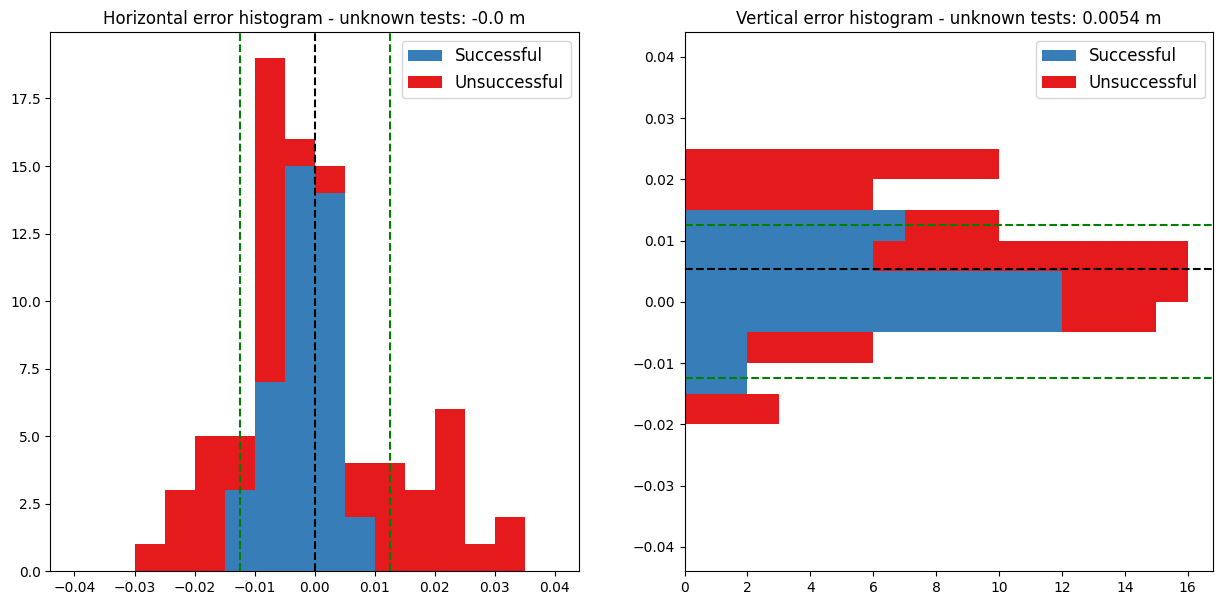

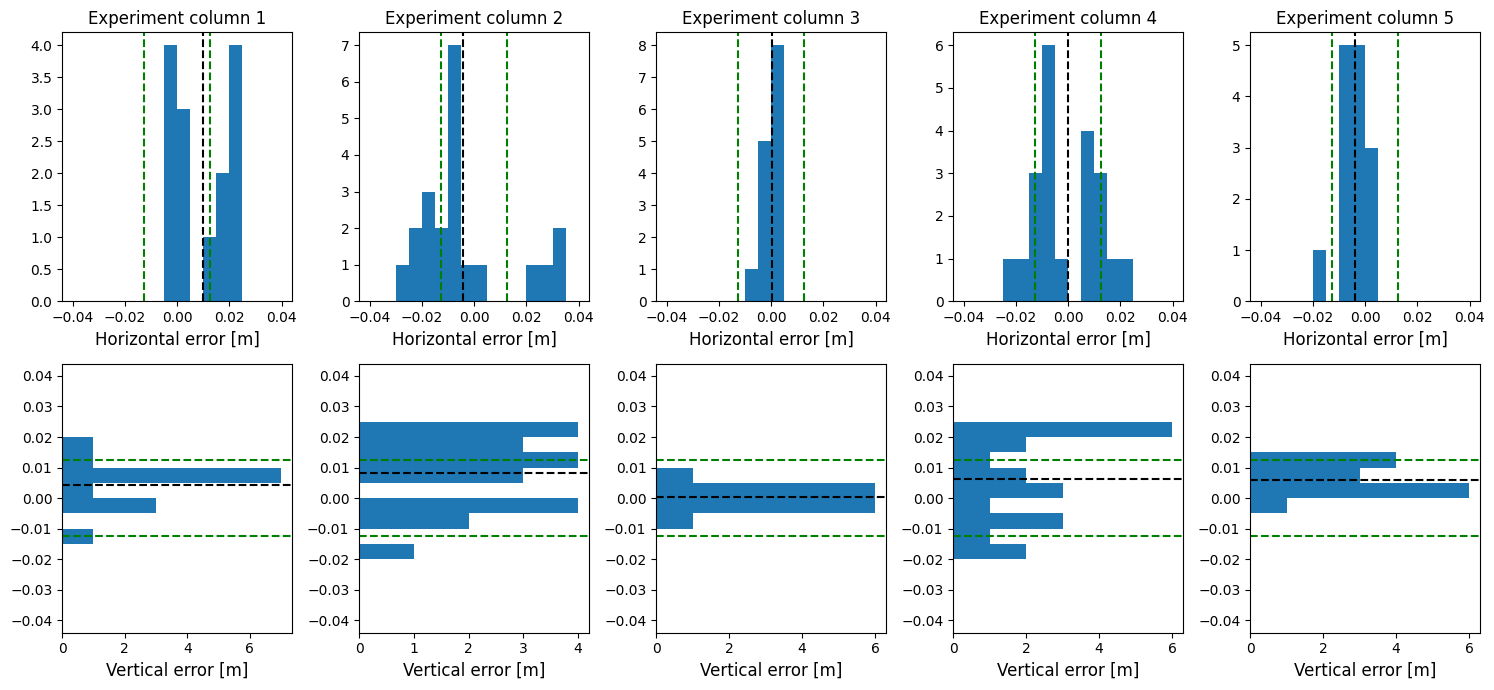

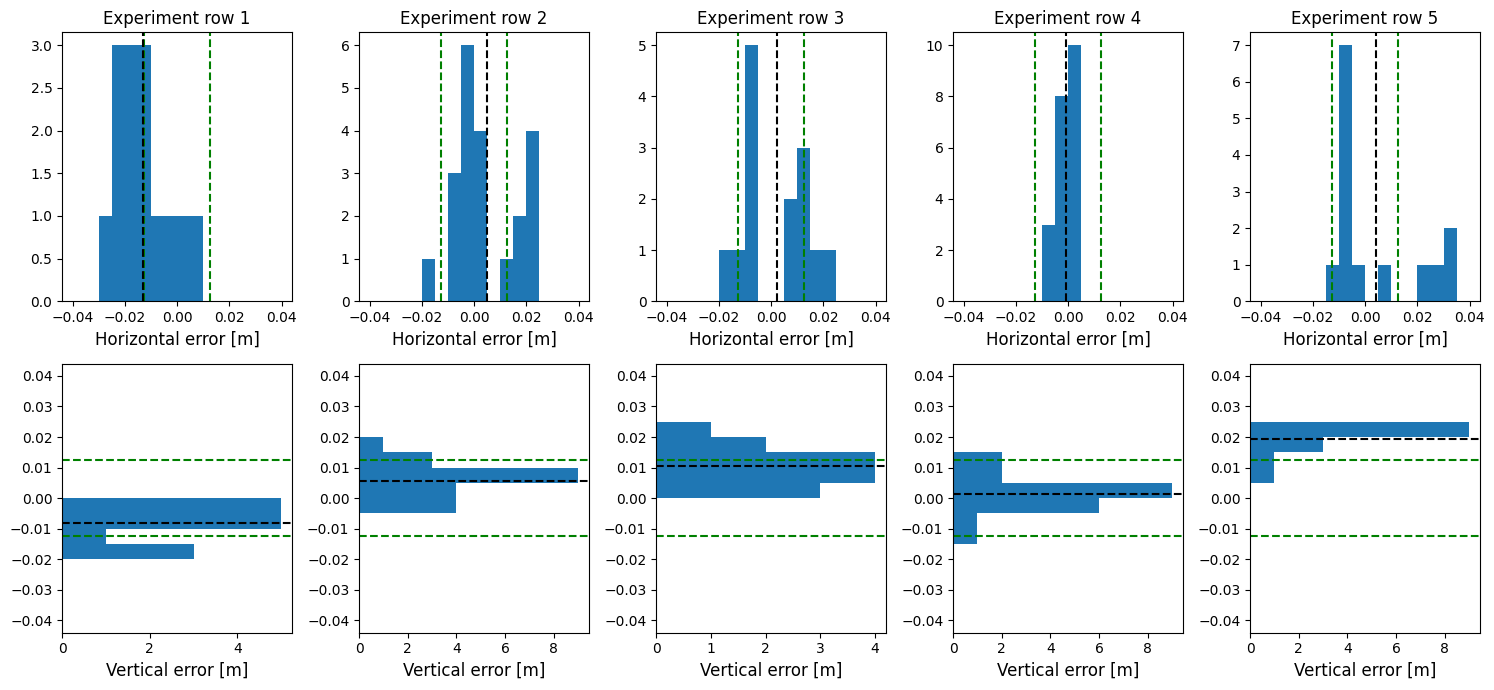

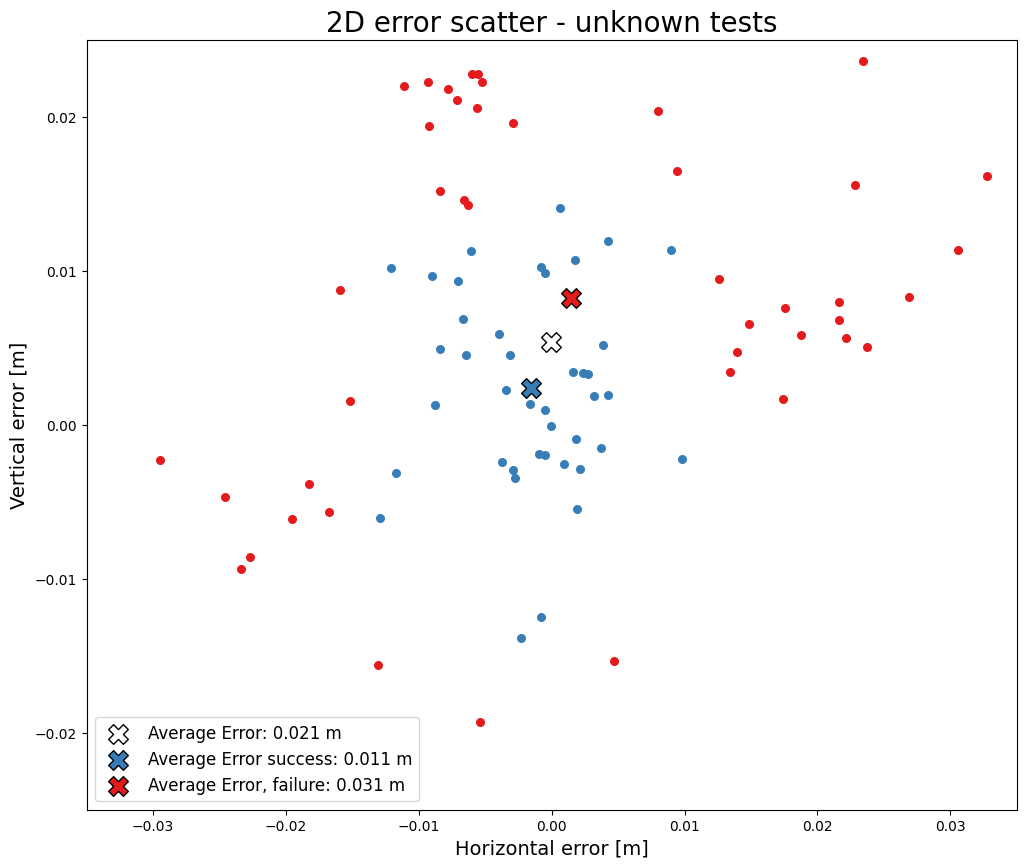

In [65]:
############UNKNOWN ERROR ANALYSIS############
# Define bin width
bins = np.arange(-0.04, 0.04+bin_width, bin_width)
d_xy_unknown = d_xy[1::2,:,:]  # Select every second episode (unknown)
d_xy_reshape = d_xy_unknown.transpose(0,2,1).reshape(-1, 3)
succ_reshaped = success.reshape(-1, 7)
selected_groups = succ_reshaped[1::2]
succ_unknown = selected_groups.reshape(-1)

avg_err_x_unknown = np.mean(d_xy_reshape[:, 1])
avg_err_y_unknown = np.mean(d_xy_reshape[:, 0])
avg_err_unknown = round(np.mean(np.linalg.norm(d_xy_reshape, axis=1)),3)

avg_err_x_succ_unknown = np.mean(d_xy_reshape[succ_unknown == 1, 1])
avg_err_y_succ_unknown = np.mean(d_xy_reshape[succ_unknown == 1, 0])
avg_err_succ_unknown = round(np.mean(np.linalg.norm(d_xy_reshape[succ_unknown == 1], axis=1)),3)

avg_err_x_failed_unknown = np.mean(d_xy_reshape[succ_unknown == 0, 1])
avg_err_y_failed_unknown = np.mean(d_xy_reshape[succ_unknown == 0, 0]) 
avg_err_failed_unknown = round(np.mean(np.linalg.norm(d_xy_reshape[succ_unknown == 0], axis=1)),3)

fig_uea, axs_uea = plt.subplots(1,2, figsize=(15, 7))

d_x_unknown_hist = [d_xy_unknown[:,1,:].flatten()[succ_unknown == 1], d_xy_unknown[:,1,:].flatten()[succ_unknown == 0]]
axs_uea[0].hist(d_x_unknown_hist,label=['Successful','Unsuccessful'], color=[colors[1], colors[0]], stacked = True, bins=bins)
axs_uea[0].set_title("Horizontal error histogram - unknown tests: "+str(round(avg_err_x_unknown,4)) + " m")
axs_uea[0].axvline(0.0125, color='green', linestyle='--')
axs_uea[0].axvline(-0.0125, color='green', linestyle='--')
axs_uea[0].axvline(avg_err_x_unknown, color='black', linestyle='--')
axs_uea[0].legend(fontsize=12)

d_y_unknown_hist = [d_xy_unknown[:,0,:].flatten()[succ_unknown == 1], d_xy_unknown[:,0,:].flatten()[succ_unknown == 0]]
axs_uea[1].hist(d_y_unknown_hist,label=['Successful','Unsuccessful'], color=[colors[1], colors[0]], stacked = True, bins=bins, orientation='horizontal')
axs_uea[1].set_title("Vertical error histogram - unknown tests: "+str(round(avg_err_y_unknown,4)) + " m")
axs_uea[1].axhline(0.0125, color='green', linestyle='--')
axs_uea[1].axhline(-0.0125, color='green', linestyle='--')
axs_uea [1].axhline(avg_err_y_unknown, color='black', linestyle='--')
axs_uea[1].legend(fontsize=12)


#### COLUMNS ####
fig_uea_col, axs_uea_col = plt.subplots(2,5, figsize=(15, 7))
cols = [[2,7],[0,5,10],[3,8],[1,6,11],[4,9]]

for i in range(5):
    axs_uea_col[0,i].set_title("Experiment column " + str(i+1))
    axs_uea_col[0,i].set_xlabel("Horizontal error [m]", fontsize=12)
    axs_uea_col[1,i].set_xlabel("Vertical error [m]", fontsize=12)
    axs_uea_col[0,i].tick_params(labelsize=10)
    axs_uea_col[1,i].tick_params(labelsize=10)
    axs_uea_col[0,i].hist(d_xy_unknown[cols[i],1,:].flatten(), bins=bins)
    axs_uea_col[1,i].hist(d_xy_unknown[cols[i],0,:].flatten(), bins=bins, orientation='horizontal')

    avg_err_x_uea_col = np.mean(d_xy_unknown[cols[i],1,:].flatten())
    avg_err_y_uea_col = np.mean(d_xy_unknown[cols[i],0,:].flatten())
    
    axs_uea_col[0,i].axvline(0.0125, color='green', linestyle='--')
    axs_uea_col[0,i].axvline(-0.0125, color='green', linestyle='--')
    axs_uea_col[0,i].axvline(avg_err_x_uea_col, color='black', linestyle='--')

    axs_uea_col[1,i].axhline(0.0125, color='green', linestyle='--')
    axs_uea_col[1,i].axhline(-0.0125, color='green', linestyle='--')
    axs_uea_col[1,i].axhline(avg_err_y_uea_col, color='black', linestyle='--')

fig_uea_col.tight_layout()

##### ROWS #####
fig_uea_row, axs_uea_row = plt.subplots(2,5, figsize=(15, 7))
rows = [[0,1],[2,3,4],[5,6],[7,8,9],[10,11]]

for i in range(5):
    axs_uea_row[0,i].set_title("Experiment row " + str(i+1))
    axs_uea_row[0,i].set_xlabel("Horizontal error [m]", fontsize=12)
    axs_uea_row[1,i].set_xlabel("Vertical error [m]", fontsize=12)
    axs_uea_row[0,i].tick_params(labelsize=10)
    axs_uea_row[1,i].tick_params(labelsize=10)
    axs_uea_row[0,i].hist(d_xy_unknown[rows[i],1,:].flatten(), bins=bins)
    axs_uea_row[1,i].hist(d_xy_unknown[rows[i],0,:].flatten(), bins=bins, orientation='horizontal')

    avg_err_x_uea_row = np.mean(d_xy_unknown[rows[i],1,:].flatten())
    avg_err_y_uea_row = np.mean(d_xy_unknown[rows[i],0,:].flatten())
    
    axs_uea_row[0,i].axvline(0.0125, color='green', linestyle='--')
    axs_uea_row[0,i].axvline(-0.0125, color='green', linestyle='--')
    axs_uea_row[0,i].axvline(avg_err_x_uea_row, color='black', linestyle='--')

    axs_uea_row[1,i].axhline(0.0125, color='green', linestyle='--')
    axs_uea_row[1,i].axhline(-0.0125, color='green', linestyle='--')
    axs_uea_row[1,i].axhline(avg_err_y_uea_row, color='black', linestyle='--')

fig_uea_row.tight_layout()

fig_uea_scatter, axs_uea_scatter = plt.subplots(1, 1, figsize=(12, 10))
axs_uea_scatter.scatter(d_xy_reshape[succ_unknown == 0,1], d_xy_reshape[succ_unknown == 0,0], color=colors[0], s = 30)
axs_uea_scatter.scatter(d_xy_reshape[succ_unknown == 1,1], d_xy_reshape[succ_unknown ==1,0], color=colors[1], s = 30)
axs_uea_scatter.scatter(avg_err_x_unknown, avg_err_y_unknown, marker='X', s=200, color='white', edgecolors= 'black', label='Average Error: '+str(avg_err_unknown) + ' m')

axs_uea_scatter.scatter(avg_err_x_succ_unknown, avg_err_y_succ_unknown, marker='X', s=200, color=colors[1], edgecolors= 'black' ,label='Average Error success: '+str(avg_err_succ_unknown) + ' m')
axs_uea_scatter.scatter(avg_err_x_failed_unknown, avg_err_y_failed_unknown, marker='X', s=200, color=colors[0], edgecolors= 'black', label='Average Error, failure: '+str(avg_err_failed_unknown) + ' m')

axs_uea_scatter.legend(fontsize = 12)
axs_uea_scatter.set_title("2D error scatter - unknown tests",fontsize=20)
axs_uea_scatter.set_xlabel("Horizontal error [m]", fontsize=14)
axs_uea_scatter.set_ylabel("Vertical error [m]", fontsize=14)
axs_uea_scatter.set_xlim(-0.035, 0.035)
axs_uea_scatter.set_ylim(-0.025, 0.025)


(84, 3)
44
72
24
35


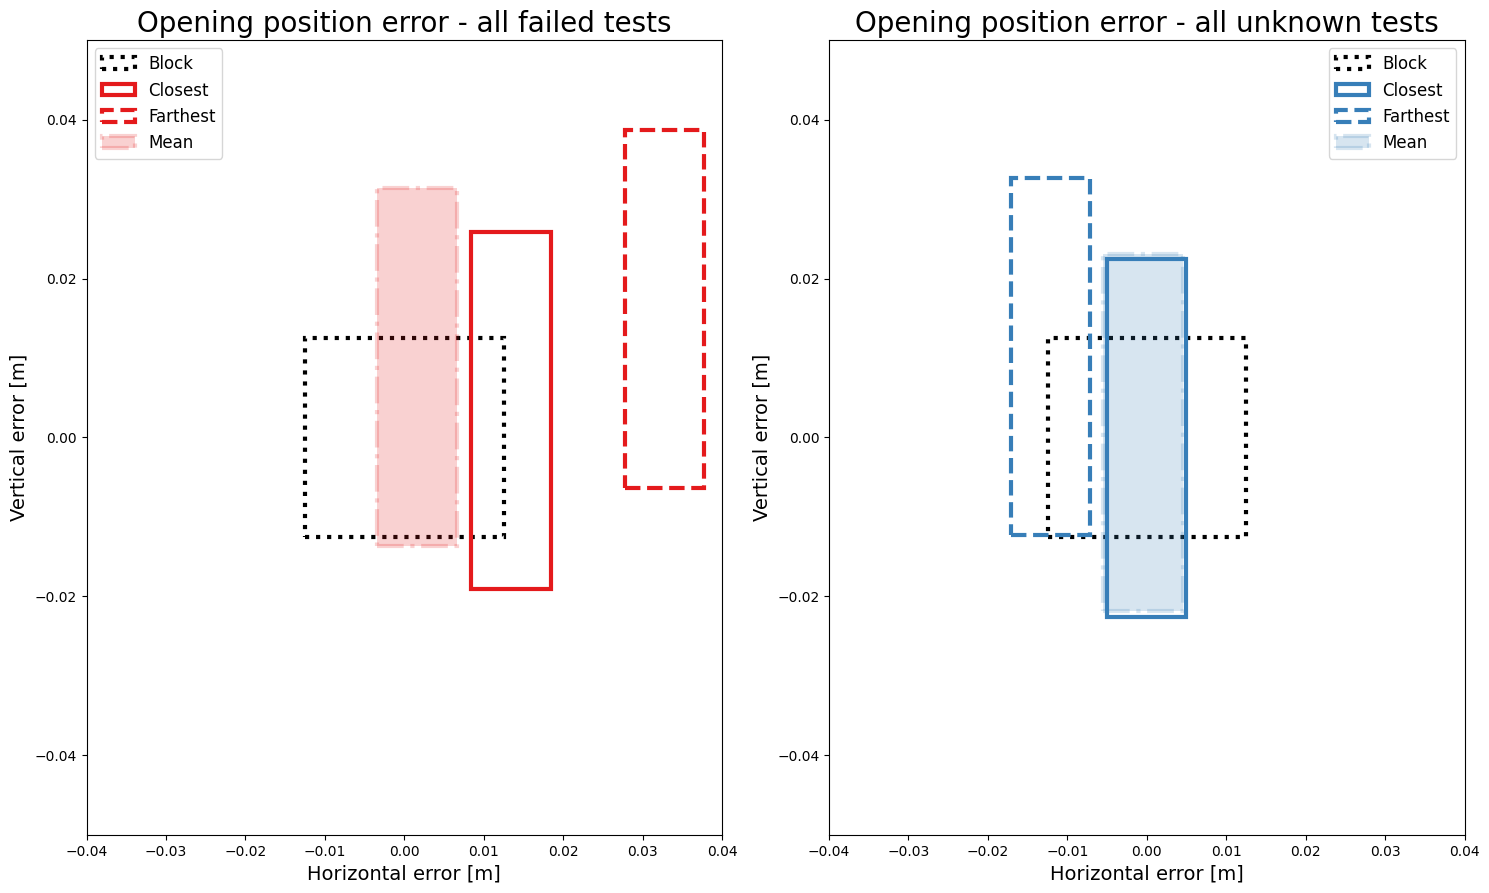

In [66]:
fig_uea_opening, axs_uea_opening = plt.subplots(1, 2, figsize=(15, 10))


box_pos = [0,0]
bottom_left = (box_pos[1]-0.0125,box_pos[0]-0.0125)
rec_u = plt.Rectangle(bottom_left,0.025,0.025, ec='black', fc='none', rotation_point="center", linewidth=3, linestyle=':', label='Block')
axs_uea_opening[0].add_patch(rec_u)
rec_s = plt.Rectangle(bottom_left,0.025,0.025, ec='black', fc='none', rotation_point="center", linewidth=3, linestyle=':',label='Block')
axs_uea_opening[1].add_patch(rec_s)

print(d_xy_reshape.shape)


# Closest unsuccessful
cu = np.argmin(d_xy_reshape[succ_unknown == 0,2])
closest_unsuccessful = d_xy_reshape[succ_unknown == 0,:][cu]
print(np.where(succ_unknown == 0)[0][cu])
rec_min_unsuccessful = plt.Rectangle((closest_unsuccessful[1]-0.005, closest_unsuccessful[0]-0.0225), 0.01, 0.045, ec=colors[0], fc='none', rotation_point="center", linewidth=3, label='Closest', linestyle='-')
axs_uea_opening[0].add_patch(rec_min_unsuccessful)

# Farthest unsuccessful
fu = np.argmax(d_xy_reshape[succ_unknown == 0,2])
farthest_unsuccessful = d_xy_reshape[succ_unknown == 0,:][fu]
print(np.where(succ_unknown == 0)[0][fu])
rec_max_unsuccessful = plt.Rectangle((farthest_unsuccessful[1]-0.005, farthest_unsuccessful[0]-0.0225), 0.01, 0.045, ec=colors[0], fc='none', rotation_point="center", linewidth=3, label='Farthest', linestyle='--')
axs_uea_opening[0].add_patch(rec_max_unsuccessful)

# mean_unsuccessful = np.mean(d_xy_reshape[success == 0,2])
mean_unsuccessful = np.mean(d_xy_reshape[succ_unknown == 0,1])
rec_mean_unsuccessful = plt.Rectangle((avg_err_x_failed-0.005, avg_err_y_failed-0.0225), 0.01, 0.045, ec=colors[0], fc=colors[0],alpha=0.2, rotation_point="center", linewidth=3,linestyle='-.', label='Mean')
axs_uea_opening[0].add_patch(rec_mean_unsuccessful)

axs_uea_opening[0].set_aspect('equal')
axs_uea_opening[0].set_xlim(-0.04, 0.04)
axs_uea_opening[0].set_ylim(-0.05, 0.05)

axs_uea_opening[0].set_title("Opening position error - all failed tests",fontsize=20)
axs_uea_opening[0].set_xlabel("Horizontal error [m]", fontsize=14)
axs_uea_opening[0].set_ylabel("Vertical error [m]", fontsize=14)

axs_uea_opening[0].legend(fontsize=12)

# Closest successful
cs = np.argmin(d_xy_reshape[succ_unknown == 1,2])
closest_successful = d_xy_reshape[succ_unknown == 1,:][cs]
print(np.where(succ_unknown == 1)[0][cs])
rec_min_successful = plt.Rectangle((closest_successful[1]-0.005, closest_successful[0]-0.0225), 0.01, 0.045, ec=colors[1], fc='none', rotation_point="center", linewidth=3, label='Closest', linestyle='-')
axs_uea_opening[1].add_patch(rec_min_successful)

# Farthest successful
fs = np.argmax(d_xy_reshape[succ_unknown == 1,2])
farthest_successful = d_xy_reshape[succ_unknown == 1,:][fs]
print(np.where(succ_unknown == 1)[0][fs])
rec_max_successful = plt.Rectangle((farthest_successful[1]-0.005, farthest_successful[0]-0.0225), 0.01, 0.045, ec=colors[1], fc='none', rotation_point="center", linewidth=3, label='Farthest',linestyle='--')
axs_uea_opening[1].add_patch(rec_max_successful)

# mean successful
mean_successful = np.mean(d_xy_reshape[succ_unknown == 1,2])
rec_mean_successful = plt.Rectangle((avg_err_x_success-0.005, avg_err_y_success-0.0225), 0.01, 0.045, ec=colors[1], fc=colors[1], alpha = 0.2, rotation_point="center", linewidth=3,linestyle='-.', label='Mean')
axs_uea_opening[1].add_patch(rec_mean_successful)

axs_uea_opening[1].set_aspect('equal')
axs_uea_opening[1].set_xlim(-0.04, 0.04)
axs_uea_opening[1].set_ylim(-0.05, 0.05)

axs_uea_opening[1].set_title("Opening position error - all unknown tests",fontsize=20)
axs_uea_opening[1].set_xlabel("Horizontal error [m]", fontsize=14)
axs_uea_opening[1].set_ylabel("Vertical error [m]", fontsize=14)

axs_uea_opening[1].legend(fontsize=12)

fig_uea_opening.tight_layout()

c:\Users\nduqu\anaconda3\envs\lerobot2\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nduqu\anaconda3\envs\lerobot2\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(-0.025, 0.025)

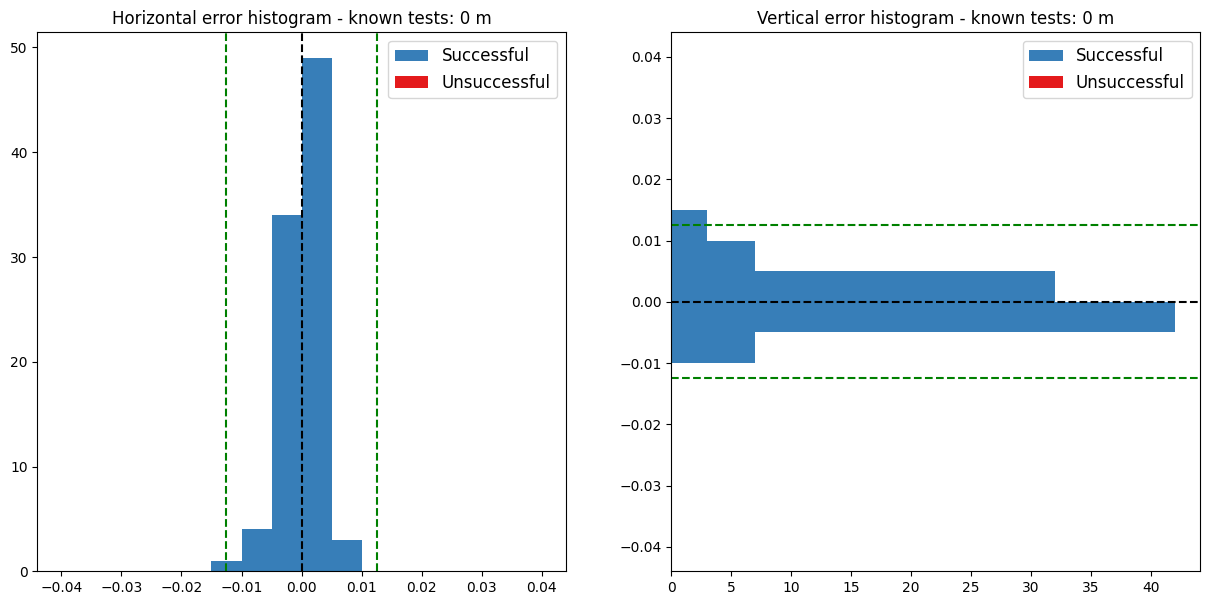

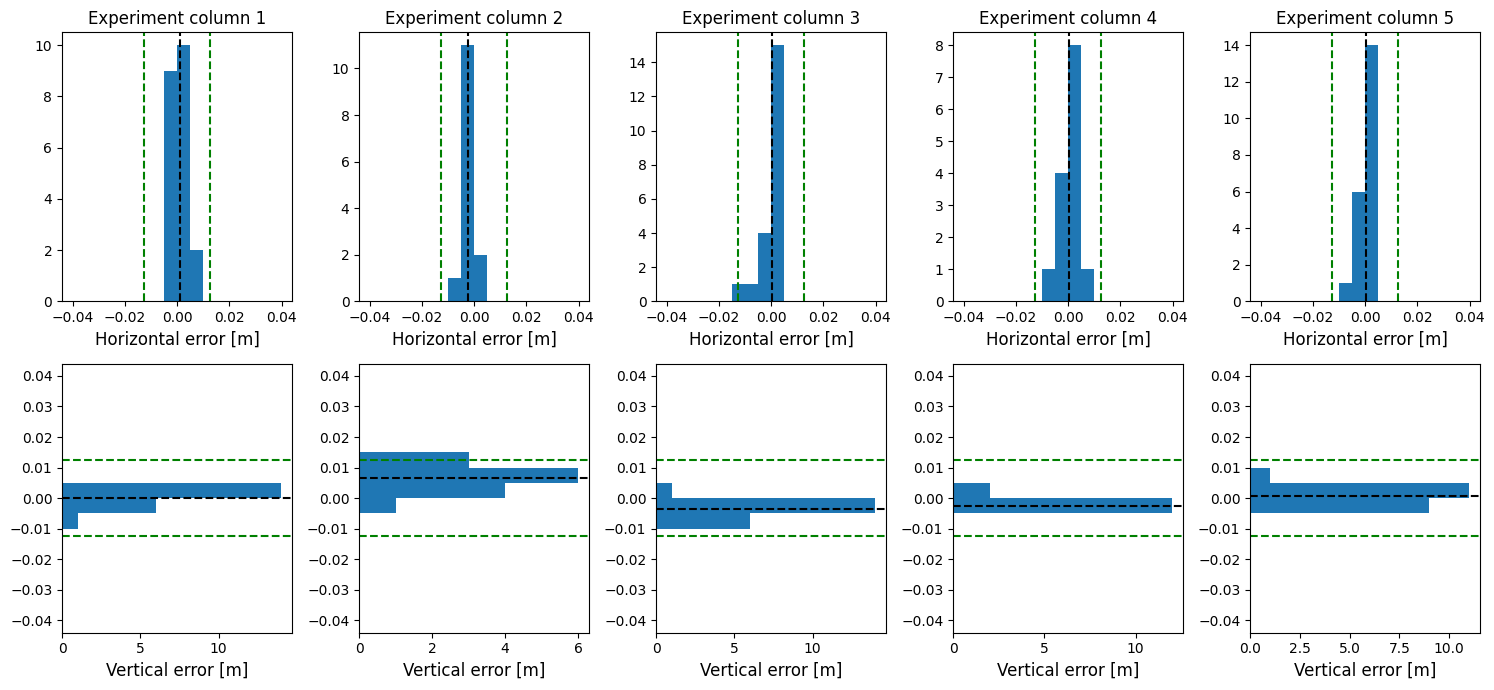

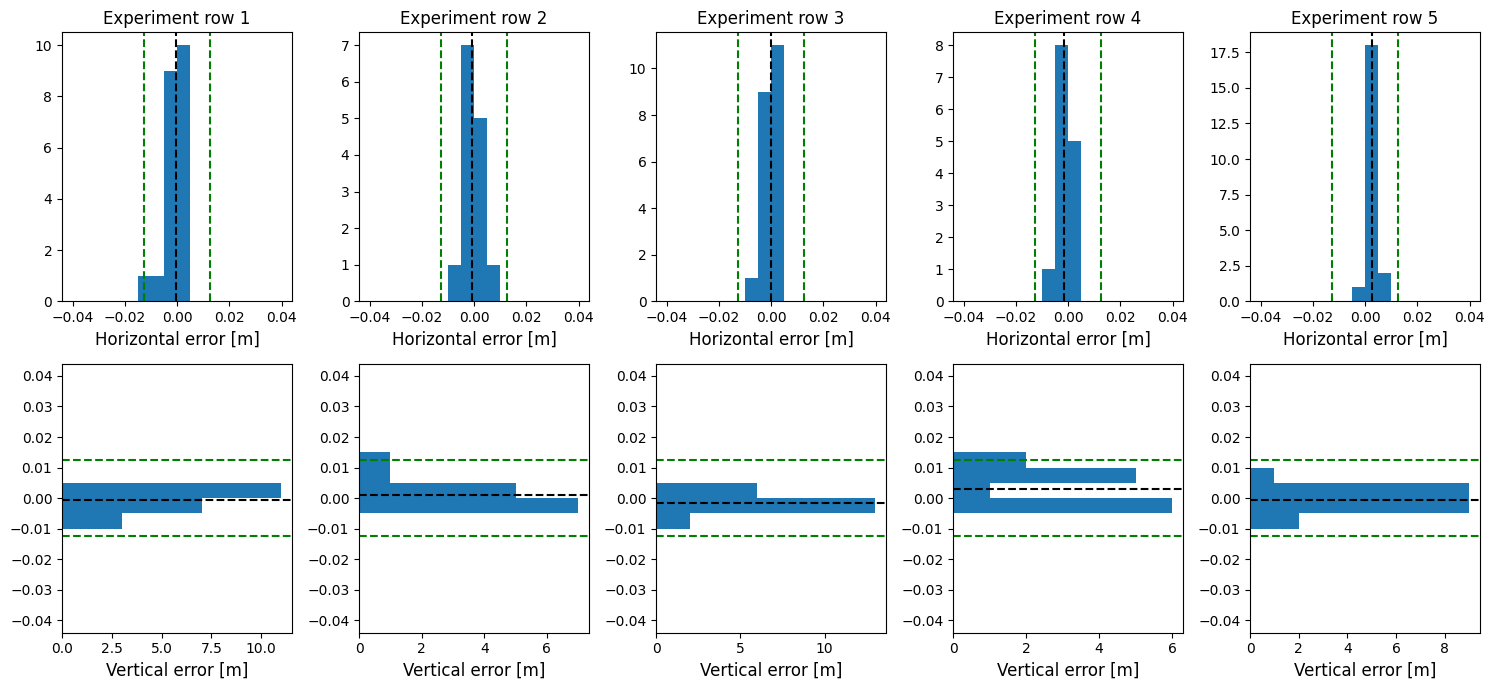

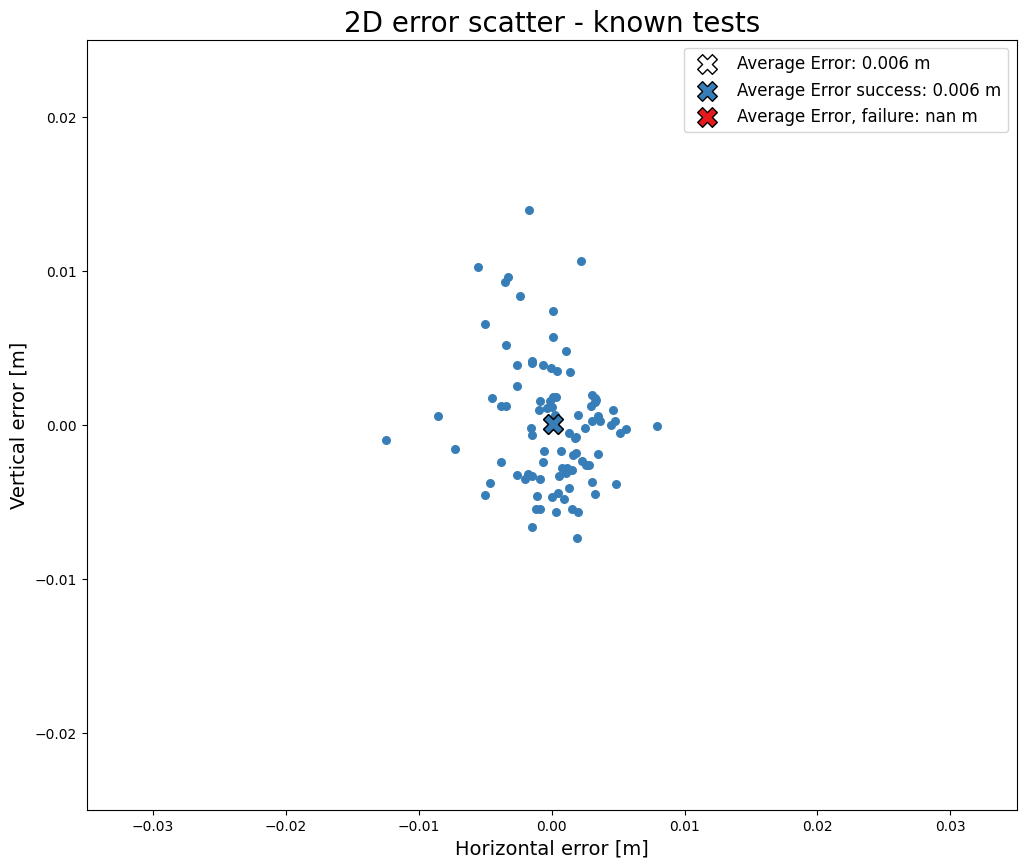

In [67]:
############KNOWN ERROR ANALYSIS############
# Define bin width
bins = np.arange(-0.04, 0.04+bin_width, bin_width)
d_xy_known = d_xy[0::2,:,:]  # Select every second episode (known)
d_xy_reshape = d_xy_known.transpose(0,2,1).reshape(-1, 3)
succ_reshaped = success.reshape(-1, 7)
selected_groups = succ_reshaped[0::2]
succ_known = selected_groups.reshape(-1)

avg_err_x_known = np.mean(d_xy_reshape[:, 1])
avg_err_y_known = np.mean(d_xy_reshape[:, 0])
avg_err_known = round(np.mean(np.linalg.norm(d_xy_reshape, axis=1)),3)

avg_err_x_succ_known = np.mean(d_xy_reshape[succ_known == 1, 1])
avg_err_y_succ_known = np.mean(d_xy_reshape[succ_known == 1, 0])
avg_err_succ_known = round(np.mean(np.linalg.norm(d_xy_reshape[succ_known == 1], axis=1)),3)

avg_err_x_failed_known = np.mean(d_xy_reshape[succ_known == 0, 1])
avg_err_y_failed_known = np.mean(d_xy_reshape[succ_known == 0, 0]) 
avg_err_failed_known = round(np.mean(np.linalg.norm(d_xy_reshape[succ_known == 0], axis=1)),3)

fig_kea, axs_kea = plt.subplots(1,2, figsize=(15, 7))

d_x_known_hist = [d_xy_known[:,1,:].flatten()[succ_known == 1], d_xy_known[:,1,:].flatten()[succ_known == 0]]
axs_kea[0].hist(d_x_known_hist,label=['Successful','Unsuccessful'], color=[colors[1], colors[0]], stacked = True, bins=bins)
axs_kea[0].set_title("Horizontal error histogram - known tests: "+str(round(avg_err_x_known)) + " m")
axs_kea[0].axvline(0.0125, color='green', linestyle='--')
axs_kea[0].axvline(-0.0125, color='green', linestyle='--')
axs_kea[0].axvline(avg_err_x_known, color='black', linestyle='--')
axs_kea[0].legend(fontsize=12)

d_y_known_hist = [d_xy_known[:,0,:].flatten()[succ_known == 1], d_xy_known[:,0,:].flatten()[succ_known == 0]]
axs_kea[1].hist(d_y_known_hist,label=['Successful','Unsuccessful'], color=[colors[1], colors[0]], stacked = True, bins=bins, orientation='horizontal')
axs_kea[1].set_title("Vertical error histogram - known tests: "+str(round(avg_err_y_known)) + " m")
axs_kea[1].axhline(0.0125, color='green', linestyle='--')
axs_kea[1].axhline(-0.0125, color='green', linestyle='--')
axs_kea[1].axhline(avg_err_y_known, color='black', linestyle='--')
axs_kea[1].legend(fontsize=12)

#### COLUMNS ####
fig_kea_col, axs_kea_col = plt.subplots(2,5, figsize=(15, 7))
cols = [[0,5,10],[3,8],[1,6,11],[4,9],[2,7,12]]

for i in range(5):
      axs_kea_col[0,i].set_title("Experiment column " + str(i+1))
      axs_kea_col[0,i].set_xlabel("Horizontal error [m]", fontsize=12)
      axs_kea_col[1,i].set_xlabel("Vertical error [m]", fontsize=12)
      axs_kea_col[0,i].tick_params(labelsize=10)
      axs_kea_col[1,i].tick_params(labelsize=10)
      axs_kea_col[0,i].hist(d_xy_known[cols[i],1,:].flatten(), bins=bins)
      axs_kea_col[1,i].hist(d_xy_known[cols[i],0,:].flatten(), bins=bins, orientation='horizontal')

      avg_err_x_kea_col = np.mean(d_xy_known[cols[i],1,:].flatten())
      avg_err_y_kea_col = np.mean(d_xy_known[cols[i],0,:].flatten())
    
      axs_kea_col[0,i].axvline(0.0125, color='green', linestyle='--')
      axs_kea_col[0,i].axvline(-0.0125, color='green', linestyle='--')
      axs_kea_col[0,i].axvline(avg_err_x_kea_col, color='black', linestyle='--')

      axs_kea_col[1,i].axhline(0.0125, color='green', linestyle='--')
      axs_kea_col[1,i].axhline(-0.0125, color='green', linestyle='--')
      axs_kea_col[1,i].axhline(avg_err_y_kea_col, color='black', linestyle='--')

fig_kea_col.tight_layout()

##### ROWS #####
fig_kea_row, axs_kea_row = plt.subplots(2,5, figsize=(15, 7))
rows = [[0,1,2],[3,4],[5,6,7],[8,9],[10,11,12]]

for i in range(5):
      axs_kea_row[0,i].set_title("Experiment row " + str(i+1))
      axs_kea_row[0,i].set_xlabel("Horizontal error [m]", fontsize=12)
      axs_kea_row[1,i].set_xlabel("Vertical error [m]", fontsize=12)
      axs_kea_row[0,i].tick_params(labelsize=10)
      axs_kea_row[1,i].tick_params(labelsize=10)
      axs_kea_row[0,i].hist(d_xy_known[rows[i],1,:].flatten(), bins=bins)
      axs_kea_row[1,i].hist(d_xy_known[rows[i],0,:].flatten(), bins=bins, orientation='horizontal')

      avg_err_x_kea_row = np.mean(d_xy_known[rows[i],1,:].flatten())
      avg_err_y_kea_row = np.mean(d_xy_known[rows[i],0,:].flatten())
    
      axs_kea_row[0,i].axvline(0.0125, color='green', linestyle='--')
      axs_kea_row[0,i].axvline(-0.0125, color='green', linestyle='--')
      axs_kea_row[0,i].axvline(avg_err_x_kea_row, color='black', linestyle='--')

      axs_kea_row[1,i].axhline(0.0125, color='green', linestyle='--')
      axs_kea_row[1,i].axhline(-0.0125, color='green', linestyle='--')
      axs_kea_row[1,i].axhline(avg_err_y_kea_row, color='black', linestyle='--')

fig_kea_row.tight_layout()

fig_kea_scatter, axs_kea_scatter = plt.subplots(1, 1, figsize=(12, 10))
axs_kea_scatter.scatter(d_xy_reshape[succ_known == 0,1], d_xy_reshape[succ_known == 0,0], color=colors[0], s = 30)
axs_kea_scatter.scatter(d_xy_reshape[succ_known == 1,1], d_xy_reshape[succ_known ==1,0], color=colors[1], s = 30)
axs_kea_scatter.scatter(avg_err_x_known, avg_err_y_known, marker='X', s=200, color='white', edgecolors= 'black', label='Average Error: '+str(avg_err_known) + ' m')

axs_kea_scatter.scatter(avg_err_x_succ_known, avg_err_y_succ_known, marker='X', s=200, color=colors[1], edgecolors= 'black' ,label='Average Error success: '+str(avg_err_succ_known) + ' m')
axs_kea_scatter.scatter(avg_err_x_failed_known, avg_err_y_failed_known, marker='X', s=200, color=colors[0], edgecolors= 'black', label='Average Error, failure: '+str(avg_err_failed_known) + ' m')

axs_kea_scatter.legend(fontsize = 12)
axs_kea_scatter.set_title("2D error scatter - known tests",fontsize=20)
axs_kea_scatter.set_xlabel("Horizontal error [m]", fontsize=14)
axs_kea_scatter.set_ylabel("Vertical error [m]", fontsize=14)

axs_kea_scatter.set_xlim(-0.035, 0.035)
axs_kea_scatter.set_ylim(-0.025, 0.025)

(91, 3)
88
60
[ 0.01391794 -0.00171022  0.01402262]


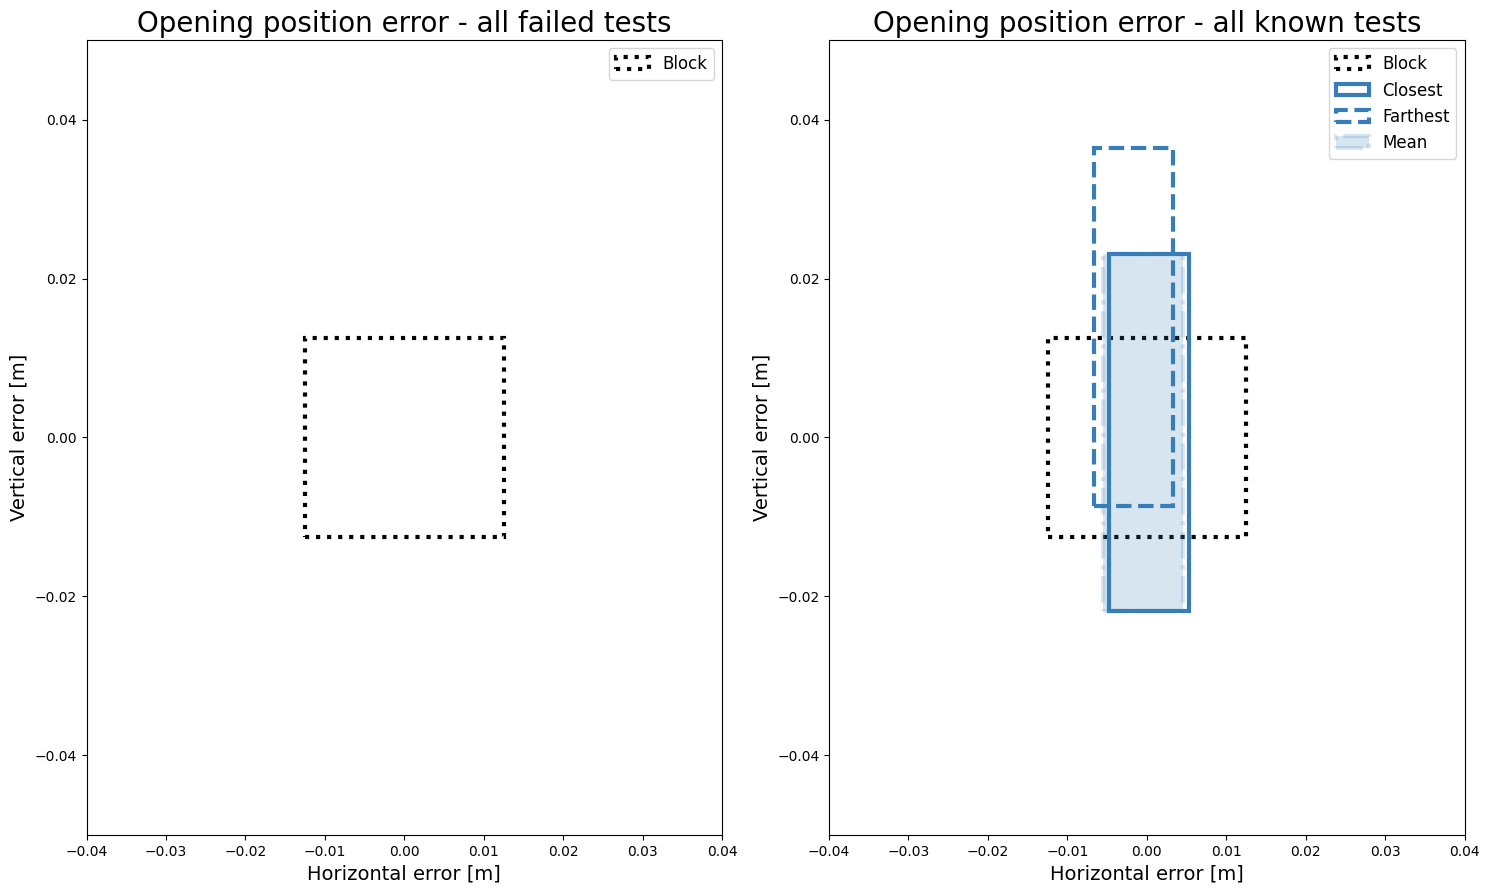

In [73]:
fig_kea_opening, axs_kea_opening = plt.subplots(1, 2, figsize=(15, 10))


box_pos = [0,0]
bottom_left = (box_pos[1]-0.0125,box_pos[0]-0.0125)
rec_u = plt.Rectangle(bottom_left,0.025,0.025, ec='black', fc='none', rotation_point="center", linewidth=3, linestyle=':', label='Block')
axs_kea_opening[0].add_patch(rec_u)
rec_s = plt.Rectangle(bottom_left,0.025,0.025, ec='black', fc='none', rotation_point="center", linewidth=3, linestyle=':',label='Block')
axs_kea_opening[1].add_patch(rec_s)

print(d_xy_reshape.shape)

'''


# Closest unsuccessful
cu = np.argmin(d_xy_reshape[succ_known == 0,2])
closest_unsuccessful = d_xy_reshape[succ_known == 0,:][cu]
print(np.where(succ_unknown == 0)[0][cu])
rec_min_unsuccessful = plt.Rectangle((closest_unsuccessful[1]-0.005, closest_unsuccessful[0]-0.0225), 0.01, 0.045, ec=colors[0], fc='none', rotation_point="center", linewidth=3, label='Closest', linestyle='-')
axs_uea_opening[0].add_patch(rec_min_unsuccessful)

# Farthest unsuccessful
fu = np.argmax(d_xy_reshape[succ_known == 0,2])
farthest_unsuccessful = d_xy_reshape[succ_known == 0,:][fu]
print(np.where(succ_known == 0)[0][fu])
rec_max_unsuccessful = plt.Rectangle((farthest_unsuccessful[1]-0.005, farthest_unsuccessful[0]-0.0225), 0.01, 0.045, ec=colors[0], fc='none', rotation_point="center", linewidth=3, label='Farthest', linestyle='--')
axs_kea_opening[0].add_patch(rec_max_unsuccessful)

# mean_unsuccessful = np.mean(d_xy_reshape[success == 0,2])
mean_unsuccessful = np.mean(d_xy_reshape[succ_known == 0,1])
rec_mean_unsuccessful = plt.Rectangle((avg_err_x_failed-0.005, avg_err_y_failed-0.0225), 0.01, 0.045, ec=colors[0], fc=colors[0],alpha=0.2, rotation_point="center", linewidth=3,linestyle='-.', label='Mean')
axs_kea_opening[0].add_patch(rec_mean_unsuccessful)
'''
axs_kea_opening[0].set_aspect('equal')
axs_kea_opening[0].set_xlim(-0.04, 0.04)
axs_kea_opening[0].set_ylim(-0.05, 0.05)

axs_kea_opening[0].set_title("Opening position error - all failed tests",fontsize=20)
axs_kea_opening[0].set_xlabel("Horizontal error [m]", fontsize=14)
axs_kea_opening[0].set_ylabel("Vertical error [m]", fontsize=14)

axs_kea_opening[0].legend(fontsize=12)

# Closest successful
cs = np.argmin(d_xy_reshape[succ_known == 1,2])
closest_successful = d_xy_reshape[succ_known == 1,:][cs]
print(np.where(succ_known == 1)[0][cs])
rec_min_successful = plt.Rectangle((closest_successful[1]-0.005, closest_successful[0]-0.0225), 0.01, 0.045, ec=colors[1], fc='none', rotation_point="center", linewidth=3, label='Closest', linestyle='-')
axs_kea_opening[1].add_patch(rec_min_successful)

# Farthest successful
fs = np.argmax(d_xy_reshape[succ_known == 1,2])
farthest_successful = d_xy_reshape[succ_known == 1,:][fs]
print(np.where(succ_known == 1)[0][fs])
print(farthest_successful)
rec_max_successful = plt.Rectangle((farthest_successful[1]-0.005, farthest_successful[0]-0.0225), 0.01, 0.045, ec=colors[1], fc='none', rotation_point="center", linewidth=3, label='Farthest',linestyle='--')
axs_kea_opening[1].add_patch(rec_max_successful)

# mean successful
mean_successful = np.mean(d_xy_reshape[succ_known == 1,2])
rec_mean_successful = plt.Rectangle((avg_err_x_success-0.005, avg_err_y_success-0.0225), 0.01, 0.045, ec=colors[1], fc=colors[1], alpha = 0.2, rotation_point="center", linewidth=3,linestyle='-.', label='Mean')
axs_kea_opening[1].add_patch(rec_mean_successful)

axs_kea_opening[1].set_aspect('equal')
axs_kea_opening[1].set_xlim(-0.04, 0.04)
axs_kea_opening[1].set_ylim(-0.05, 0.05)

axs_kea_opening[1].set_title("Opening position error - all known tests",fontsize=20)
axs_kea_opening[1].set_xlabel("Horizontal error [m]", fontsize=14)
axs_kea_opening[1].set_ylabel("Vertical error [m]", fontsize=14)

axs_kea_opening[1].legend(fontsize=12)

fig_kea_opening.tight_layout()

#### Gripper opening analysis ####

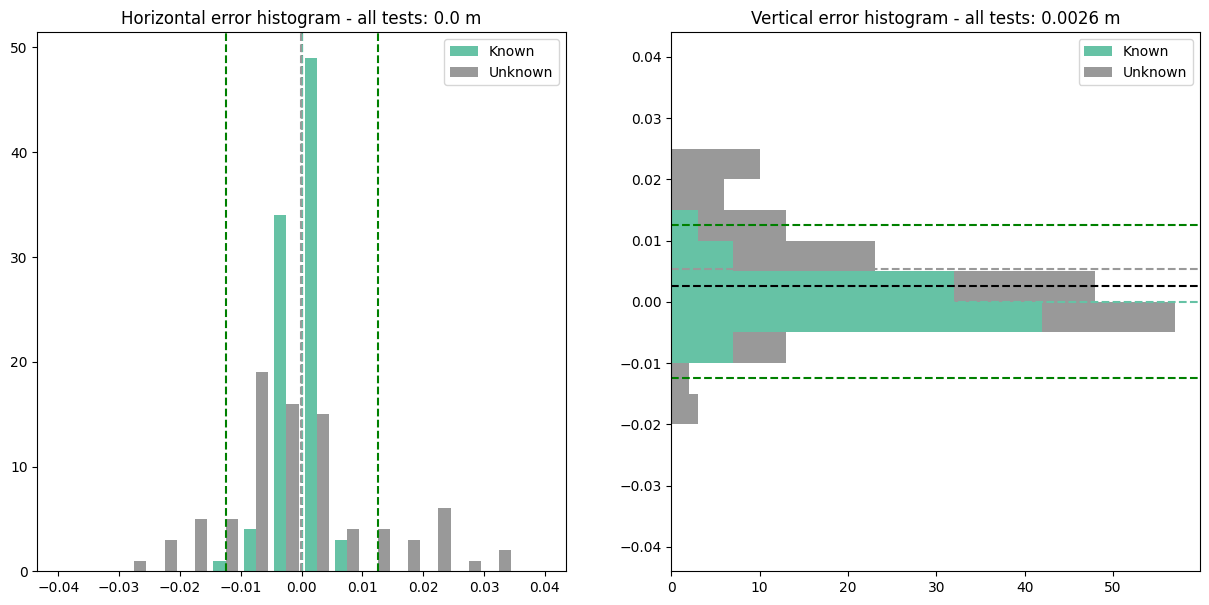

### Ablation study ###


In [126]:
repo_id_og="nduque/eval_robustness_e9_3_full_og_cluster_180k"


success_e9_3_full_og_cluster_180k =   np.array([1,1,1,1,1,1,1, #1
                                                0,0,0,0,0,0,0, #2
                                                1,1,1,1,1,1,1, #3
                                                1,1,1,1,1,1,0, #4 
                                                1,1,1,1,1,1,1, #5
                                                0,0,0,0,0,0,0, #6
                                                1,1,1,1,1,1,1, #7
                                                1,0,1,1,1,1,0, #8
                                                1,1,1,1,1,1,1, #9
                                                0,0,1,1,1,0,0, #10
                                                1,1,1,1,0,0,0, #11
                                                0,0,0,0,0,0,0, #12 
                                                1,1,1,1,1,1,1, #13 
                                                1,1,0,0,0,0,1, #14
                                                1,1,1,1,1,1,1, #15
                                                0,0,0,0,0,0,0, #16
                                                1,1,1,1,1,1,1, #17
                                                1,1,1,1,1,1,1, #18
                                                1,1,1,1,1,1,1, #19
                                                1,1,0,1,1,1,1, #20
                                                1,1,1,1,1,1,1, #21
                                                0,0,0,0,0,0,0, #22
                                                1,1,1,1,1,1,1, #23
                                                0,0,0,0,0,0,0, #24
                                                1,1,1,1,1,1,1  #25
                                                ]) 
dataset_og = LeRobotDataset(repo_id_og)
observations_og = dataset_og.hf_dataset.select_columns("observation.state")['observation.state']
episodes_og = list(range(dataset_og.meta.total_episodes))
episode_data_index_og=get_episode_data_index(dataset_og.meta.episodes)

repo_id_fk="nduque/eval_robustness_e9_3_full_fk_local_240k"
success_e9_3_full_fk_local_240k = np.array([1,1,1,1,1,1,1, #1
                                                1,1,1,1,1,1,1, #2
                                                1,1,1,1,1,1,1, #3
                                                0,0,0,1,0,1,1, #4
                                                1,1,1,1,1,1,1, #5
                                                0,0,0,0,0,0,0, #6
                                                1,1,1,1,1,1,1, #7
                                                0,1,1,1,1,1,1, #8
                                                1,1,1,1,1,1,1, #9
                                                0,0,0,0,0,0,0, #10
                                                1,1,1,1,1,1,1, #11
                                                0,0,0,0,0,0,0, #12 
                                                1,1,1,1,1,1,1, #13 
                                                0,0,0,1,1,0,1, #14
                                                1,1,1,1,1,1,1, #15
                                                0,1,0,1,0,1,0, #16
                                                1,1,1,1,1,1,1, #17
                                                1,1,1,1,1,1,1, #18
                                                1,1,1,1,1,1,1, #19
                                                1,0,0,0,0,0,1, #20
                                                1,1,1,1,1,1,1, #21
                                                0,0,0,0,0,0,0, #22
                                                1,1,1,1,1,1,1, #23
                                                0,0,0,0,0,0,0, #24
                                                1,1,1,1,1,1,1  #25
                                                ]) 
dataset_fk = LeRobotDataset(repo_id_fk)
observations_fk = dataset_fk.hf_dataset.select_columns("observation.state")['observation.state']
episodes_fk = list(range(dataset_fk.meta.total_episodes))
episode_data_index_fk=get_episode_data_index(dataset_fk.meta.episodes)
order= list(range(163)) + [175, 164, 165, 166, 176] + list(range(168,175)) #fk local 240k

# Loop through dataset
#   Get observation (poses)
#   Save grasping position
#   Save observation, real action, predicted action in dictionary
obs_grasp_og = []
grasp_angle_og = []
total_grasp_og = []

obs_grasp_fk = []
grasp_angle_fk = []
total_grasp_fk = []

obs_grasp_dp = []
grasp_angle_dp = []
total_grasp_dp = []

obs_grasp_og, grasp_angle_og = get_grasps(episodes_og, episode_data_index_og, observations_og,d,a,alpha)
obs_grasp_fk, grasp_angle_fk = get_grasps(order, episode_data_index_fk, observations_fk,d,a,alpha)
obs_grasp_dp, grasp_angle_dp = get_grasps(episodes, episode_data_index, observations,d,a,alpha)


box_pos_avg_e9_all = np.array(box_pos_avg_e9_all)
box_avg = box_pos_avg_e9_all
eps = int(len(episodes)/len(box_avg))


success_og = success_e9_3_full_og_cluster_180k
success_fk = success_e9_3_full_fk_local_240k
success_dp = success

success_accum_og = np.sum(success_og.reshape(25,7), axis=1)/7 * 100
success_accum_fk = np.sum(success_fk.reshape(25,7), axis=1)/7 * 100
success_accum_dp = success_accum




/tmp/ipykernel_647802/1510991053.py:70: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  joint_angles_rad = np.radians(joint_angles)
/tmp/ipykernel_647802/1510991053.py:77: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ct, st = np.cos(theta), np.sin(theta)


#### Success rate heatmap comparisons ####

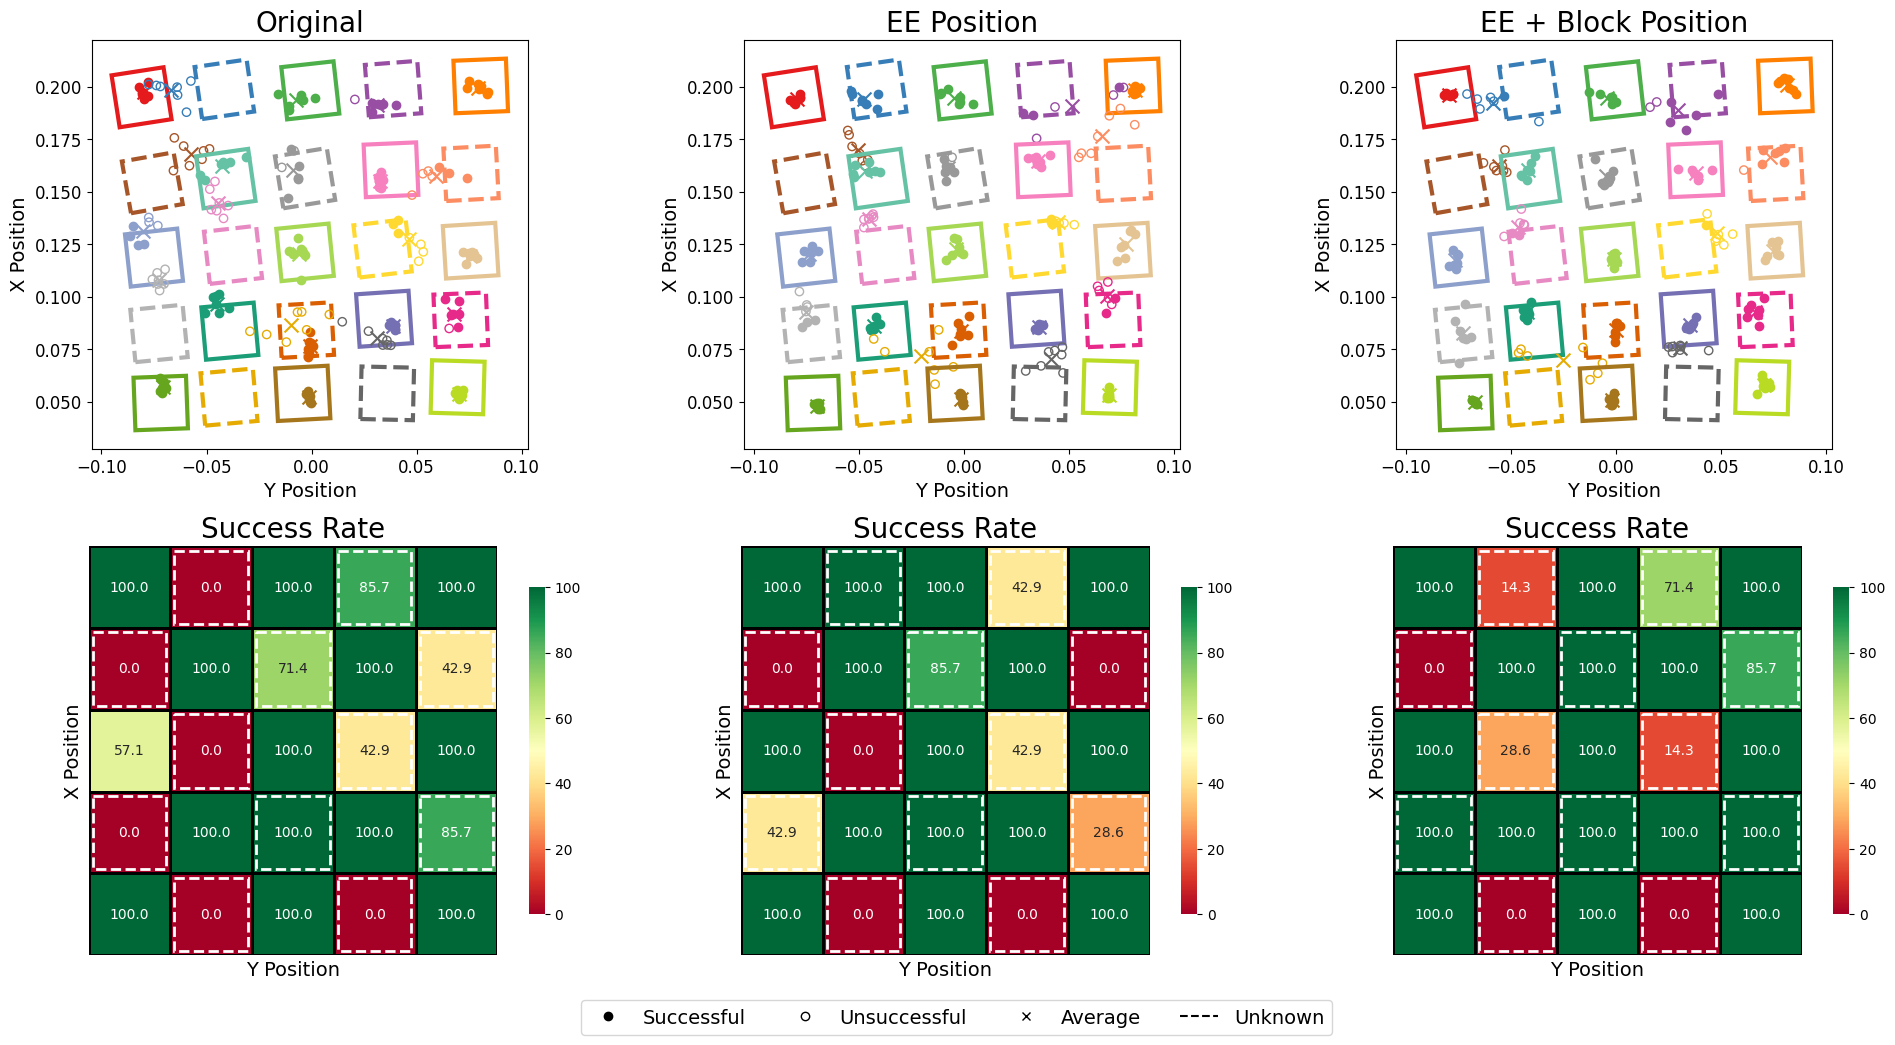

In [132]:

fig_comp_hm, axs_comp_hm = plt.subplots(2, 3, figsize=(20, 10))
eps = int(len(episodes)/len(box_avg))
d_xy_dp = []
avg_ep_dp = []
avg_err_dp = []

d_xy_fk = []
avg_ep_fk = []
avg_err_fk = []

d_xy_og = []
avg_ep_og = []
avg_err_og = []

##### GRASPING POSITIONS #####
for i in range(len(box_avg)):
    color=colors[i]
    box_pos = box_avg[i]

    ## OG averages
    avg_ep, d_xy, avg_err = get_averages(obs_grasp_og[i*eps:(i+1)*eps], grasp_angle_og[i*eps:(i+1)*eps], box_pos)
    avg_ep_og.append(avg_ep)
    d_xy_og.append(d_xy)
    avg_err_og.append(avg_err)
    total_grasp_og.append(obs_grasp_og[i*eps:(i+1)*eps])

    ## FK averages
    avg_ep, d_xy, avg_err = get_averages(obs_grasp_fk[i*eps:(i+1)*eps], grasp_angle_fk[i*eps:(i+1)*eps], box_pos)
    avg_ep_fk.append(avg_ep)
    d_xy_fk.append(d_xy)
    avg_err_fk.append(avg_err)
    total_grasp_fk.append(obs_grasp_fk[i*eps:(i+1)*eps])

    ## DP averages
    avg_ep, d_xy, avg_err = get_averages(obs_grasp_dp[i*eps:(i+1)*eps], grasp_angle_dp[i*eps:(i+1)*eps], box_pos)
    avg_ep_dp.append(avg_ep)
    d_xy_dp.append(d_xy)
    avg_err_dp.append(avg_err)
    total_grasp_dp.append(obs_grasp_dp[i*eps:(i+1)*eps])

    fc = color
    for j in range(eps):
            fc = 'none' if success_og[i*eps+j] == 0 else color
            axs_comp_hm[0,0].scatter(obs_grasp_og[i*eps+j,1], obs_grasp_og[i*eps+j, 0],color=color, fc=fc)
            
            fc = 'none' if success_fk[i*eps+j] == 0 else color
            axs_comp_hm[0,1].scatter(obs_grasp_fk[i*eps+j,1], obs_grasp_fk[i*eps+j, 0],color=color, fc=fc)

            fc = 'none' if success_dp[i*eps+j] == 0 else color
            axs_comp_hm[0,2].scatter(obs_grasp_dp[i*eps+j,1], obs_grasp_dp[i*eps+j, 0],color=color, fc=fc)

    axs_comp_hm[0,0].scatter(avg_ep_og[-1][1], avg_ep_og[-1][0], color=color, marker='x', s=100)
    axs_comp_hm[0,1].scatter(avg_ep_fk[-1][1], avg_ep_fk[-1][0], color=color, marker='x', s=100)
    axs_comp_hm[0,2].scatter(avg_ep_dp[-1][1], avg_ep_dp[-1][0], color=color, marker='x', s=100)

    bottom_left = (box_pos[1]-0.0125,box_pos[0]-0.0125)
    if known_mask[i//5, i%5]:
        rec_og = plt.Rectangle(bottom_left,0.025,0.025, ec=color, fc='none', angle = box_pos[2], rotation_point="center", linewidth=3)
        rec_fk = plt.Rectangle(bottom_left,0.025,0.025, ec=color, fc='none', angle = box_pos[2], rotation_point="center", linewidth=3)
        rec_dp = plt.Rectangle(bottom_left,0.025,0.025, ec=color, fc='none', angle = box_pos[2], rotation_point="center", linewidth=3)
        
    else:
        rec_og = plt.Rectangle(bottom_left,0.025,0.025, ec=color, fc='none', angle = box_pos[2], rotation_point="center", linewidth=3, linestyle='--')
        rec_fk = plt.Rectangle(bottom_left,0.025,0.025, ec=color, fc='none', angle = box_pos[2], rotation_point="center", linewidth=3, linestyle='--')
        rec_dp = plt.Rectangle(bottom_left,0.025,0.025, ec=color, fc='none', angle = box_pos[2], rotation_point="center", linewidth=3, linestyle='--')

    axs_comp_hm[0,0].add_patch(rec_og)
    axs_comp_hm[0,1].add_patch(rec_fk)
    axs_comp_hm[0,2].add_patch(rec_dp)


d_xy_og = np.array(d_xy_og)
d_xy_fk = np.array(d_xy_fk)
d_xy_dp = np.array(d_xy_dp)

titles = ["Original", "EE Position", "EE + Block Position"]

for i in range(3):
    axs_comp_hm[0,i].set_xlabel("Y Position", fontsize=14)
    axs_comp_hm[0,i].set_ylabel("X Position", fontsize=14)
    axs_comp_hm[0,i].tick_params(labelsize=12)
    axs_comp_hm[0,i].set_title(titles[i], fontsize=20)
    axs_comp_hm[0,i].set_aspect('equal')

##### HEATMAPS #####
success_accum_og = success_accum_og.reshape(5, 5)
success_accum_fk = success_accum_fk.reshape(5, 5)
success_accum_dp = success_accum_dp.reshape(5, 5)
annot_format=".1f"

sns.heatmap(success_accum_og, ax = axs_comp_hm[1,0], annot=True, fmt=annot_format, cmap="RdYlGn", cbar=True, linewidths=1,linecolor='black',vmin=0,vmax=100,square=True,cbar_kws={"shrink": 0.8})
sns.heatmap(success_accum_fk, ax = axs_comp_hm[1,1], annot=True, fmt=annot_format, cmap="RdYlGn", cbar=True, linewidths=1,linecolor='black',vmin=0,vmax=100,square=True,cbar_kws={"shrink": 0.8})
sns.heatmap(success_accum_dp, ax = axs_comp_hm[1,2],  annot=True, fmt=annot_format, cmap="RdYlGn", cbar=True, linewidths=1,linecolor='black',vmin=0,vmax=100,square=True,cbar_kws={"shrink": 0.8})

if known_mask is not None:
        for y in range(success_accum.shape[0]):
            for x in range(success_accum.shape[1]):
                if not known_mask[y, x]:
                    axs_comp_hm[1,0].add_patch(plt.Rectangle((x+0.05, y+0.05), 0.9, 0.9,fill=False, edgecolor='white',linestyle='--',lw=2))
                    axs_comp_hm[1,1].add_patch(plt.Rectangle((x+0.05, y+0.05), 0.9, 0.9,fill=False, edgecolor='white',linestyle='--',lw=2))
                    axs_comp_hm[1,2].add_patch(plt.Rectangle((x+0.05, y+0.05), 0.9, 0.9,fill=False, edgecolor='white',linestyle='--',lw=2))

for i in range(3):
    axs_comp_hm[1,i].set_xlabel("Y Position", fontsize=14)
    axs_comp_hm[1,i].set_ylabel("X Position", fontsize=14)
    axs_comp_hm[1,i].set_title("Success Rate", fontsize=20)
    axs_comp_hm[1,i].set_xticks([])
    axs_comp_hm[1,i].set_yticks([])

success_marker = mlines.Line2D([], [], color='black', marker='o', markersize=6, label='Successful', fillstyle='full', linestyle='None')
unsuccess_marker = mlines.Line2D([], [], color='black', marker='o', markersize=6, label='Unsuccessful', fillstyle='none', linestyle='None')
average_marker = mlines.Line2D([], [], color='black', marker='x', markersize=6, label='Average', fillstyle='none', linestyle='None')
unknown_marker = mlines.Line2D([], [], color='black', marker='None', markersize=6, label='Unknown', fillstyle='none', linestyle='--')
fig_comp_hm.legend(handles=[success_marker, unsuccess_marker,average_marker, unknown_marker], loc='lower right', bbox_to_anchor=(0.7,-0.05), fontsize=14, ncol=4)
fig_comp_hm.tight_layout()


#### Error histogram comparisons ####

'\n#### COLUMNS ####\nfig_gea_col, axs_gea_col = plt.subplots(2,5, figsize=(15, 7))\n\n\nfor i in range(5):\n    axs_gea_col[0,i].set_title("Experiment column " + str(i+1))\n    axs_gea_col[0,i].set_xlabel("Horizontal error [m]", fontsize=12)\n    axs_gea_col[1,i].set_xlabel("Vertical error [m]", fontsize=12)\n    axs_gea_col[0,i].tick_params(labelsize=10)\n    axs_gea_col[1,i].tick_params(labelsize=10)\n    axs_gea_col[0,i].hist(d_xy[i::5,1,:].flatten(), bins=bins)\n    axs_gea_col[1,i].hist(d_xy[i::5,0,:].flatten(), bins=bins, orientation=\'horizontal\')\n\n    avg_err_x_gea_col = np.mean(d_xy[i::5,1,:].flatten())\n    avg_err_y_gea_col = np.mean(d_xy[i::5,0,:].flatten())\n    \n    axs_gea_col[0,i].axvline(0.0125, color=\'green\', linestyle=\'--\')\n    axs_gea_col[0,i].axvline(-0.0125, color=\'green\', linestyle=\'--\')\n    axs_gea_col[0,i].axvline(avg_err_x_gea_col, color=\'black\', linestyle=\'--\')\n\n    axs_gea_col[1,i].axhline(0.0125, color=\'green\', linestyle=\'--\')\n    

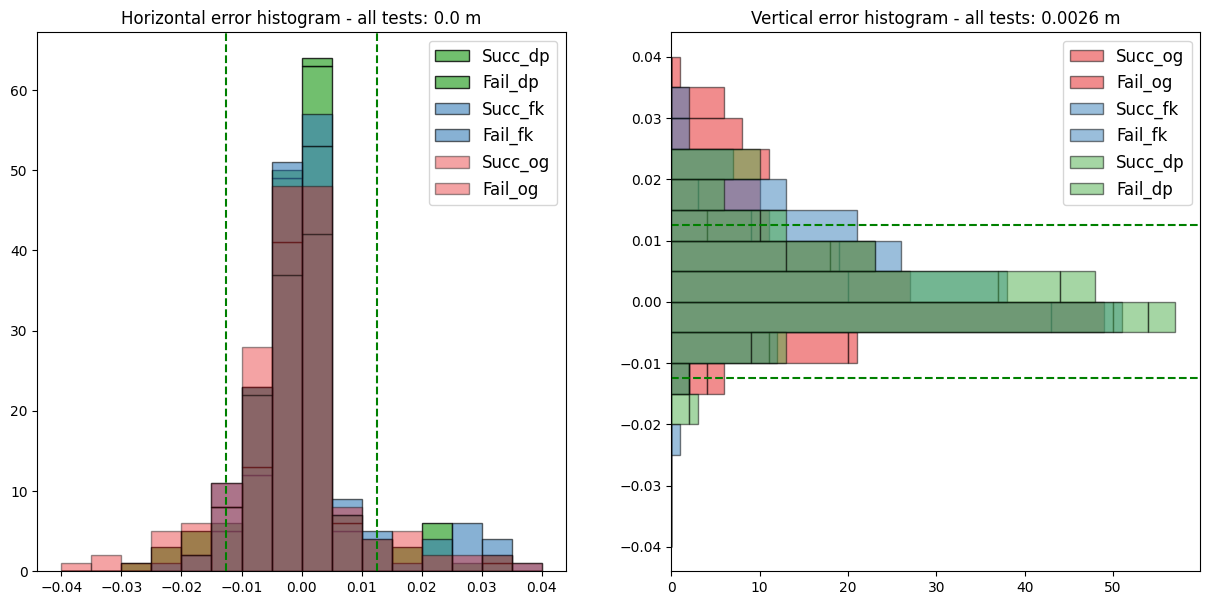

In [136]:
# Define bin width
bin_width = 0.005
########## GENERAL ERROR ANALYSIS ##########
bins = np.arange(-0.04, 0.04+bin_width, bin_width)

d_xy_reshape_og = d_xy_og.transpose(0,2,1).reshape(-1,3)
avg_err_og = [np.mean(d_xy_reshape_og[:, 1]), np.mean(d_xy_reshape_og[:, 0]), round(np.mean(np.linalg.norm(d_xy_reshape_og, axis=1)),3)]
avg_err_success_og = [np.mean(d_xy_reshape_og[success_og == 1, 1]),np.mean(d_xy_reshape_og[success_og == 1, 0]),round(np.mean(np.linalg.norm(d_xy_reshape_og[success_og == 1], axis=1)),3)]
avg_err_failed_og = [np.mean(d_xy_reshape_og[success_og == 0, 1]), np.mean(d_xy_reshape_og[success_og == 0, 0]), round(np.mean(np.linalg.norm(d_xy_reshape_og[success_og == 0], axis=1)),3)]

d_xy_reshape_fk = d_xy_fk.transpose(0,2,1).reshape(-1,3)
avg_err_fk = [np.mean(d_xy_reshape_fk[:, 1]), np.mean(d_xy_reshape_fk[:, 0]), round(np.mean(np.linalg.norm(d_xy_reshape_fk, axis=1)),3)]
avg_err_success_fk = [np.mean(d_xy_reshape_fk[success_fk == 1, 1]), np.mean(d_xy_reshape_fk[success_fk == 1, 0]), round(np.mean(np.linalg.norm(d_xy_reshape_fk[success_fk == 1], axis=1)),3)]
avg_err_failed_fk = [np.mean(d_xy_reshape_fk[success_fk == 0, 1]), np.mean(d_xy_reshape_fk[success_fk == 0, 0]), round(np.mean(np.linalg.norm(d_xy_reshape_fk[success_fk == 0], axis=1)),3)]

d_xy_reshape_dp = d_xy_dp.transpose(0,2,1).reshape(-1,3)
avg_err_dp = [np.mean(d_xy_reshape_dp[:, 1]), np.mean(d_xy_reshape_dp[:, 0]), round(np.mean(np.linalg.norm(d_xy_reshape_dp, axis=1)),3)]
avg_err_success_dp = [np.mean(d_xy_reshape_dp[success_dp == 1, 1]), np.mean(d_xy_reshape_dp[success_dp == 1, 0]), round(np.mean(np.linalg.norm(d_xy_reshape_dp[success_dp == 1], axis=1)),3)]
avg_err_failed_dp = [np.mean(d_xy_reshape_dp[success_dp == 0, 1]), np.mean(d_xy_reshape_dp[success_dp == 0, 0]), round(np.mean(np.linalg.norm(d_xy_reshape_dp[success_dp == 0], axis=1)),3)]

fig_comp_gea, axs_comp_gea = plt.subplots(1,2, figsize=(15, 7))

axs_comp_gea[0].hist([d_xy_dp[:,1,:].flatten()[success_dp == 1],d_xy_dp[:,1,:].flatten()[success_dp == 0]],label=['Succ_dp','Fail_dp'], color=[colors[2], colors[2]], stacked = True, bins=bins, alpha = 0.8, edgecolor='black')
axs_comp_gea[0].hist([d_xy_fk[:,1,:].flatten()[success_fk == 1],d_xy_fk[:,1,:].flatten()[success_fk == 0]],label=['Succ_fk','Fail_fk'], color=[colors[1], colors[1]], stacked = True, bins=bins, alpha = 0.6, edgecolor='black')
axs_comp_gea[0].hist([d_xy_og[:,1,:].flatten()[success_og == 1],d_xy_og[:,1,:].flatten()[success_og == 0]],label=['Succ_og','Fail_og'], color=[colors[0], colors[0]], stacked = True, bins=bins, alpha = 0.4, edgecolor='black')



axs_comp_gea[0].set_title("Horizontal error histogram - all tests: " + str(round(avg_err_x,4)) + " m")
axs_comp_gea[0].axvline(0.0125, color='green', linestyle='--')
axs_comp_gea[0].axvline(-0.0125, color='green', linestyle='--')
#axs_comp_gea[0].axvline(avg_err_x, color='black', linestyle='--')
axs_comp_gea[0].legend(fontsize=12)

axs_comp_gea[1].hist([d_xy_og[:,0,:].flatten()[success_og == 1],d_xy_og[:,0,:].flatten()[success_og == 0]],label=['Succ_og','Fail_og'], color=[colors[0], colors[0]], stacked = True, bins=bins, alpha = 0.5, orientation='horizontal', edgecolor='black')
axs_comp_gea[1].hist([d_xy_fk[:,0,:].flatten()[success_fk == 1],d_xy_fk[:,0,:].flatten()[success_fk == 0]],label=['Succ_fk','Fail_fk'], color=[colors[1], colors[1]], stacked = True, bins=bins, alpha = 0.5, orientation='horizontal', edgecolor='black')
axs_comp_gea[1].hist([d_xy_dp[:,0,:].flatten()[success_dp == 1],d_xy_dp[:,0,:].flatten()[success_dp == 0]],label=['Succ_dp','Fail_dp'], color=[colors[2], colors[2]], stacked = True, bins=bins, alpha = 0.5, orientation='horizontal', edgecolor='black')
axs_comp_gea[1].set_title("Vertical error histogram - all tests: " + str(round(avg_err_y,4)) + " m")
axs_comp_gea[1].axhline(0.0125, color='green', linestyle='--')
axs_comp_gea[1].axhline(-0.0125, color='green', linestyle='--')
#axs_comp_gea[1].axhline(avg_err_y, color='black', linestyle='--')
axs_comp_gea[1].legend(fontsize=12)
'''
#### COLUMNS ####
fig_gea_col, axs_gea_col = plt.subplots(2,5, figsize=(15, 7))


for i in range(5):
    axs_gea_col[0,i].set_title("Experiment column " + str(i+1))
    axs_gea_col[0,i].set_xlabel("Horizontal error [m]", fontsize=12)
    axs_gea_col[1,i].set_xlabel("Vertical error [m]", fontsize=12)
    axs_gea_col[0,i].tick_params(labelsize=10)
    axs_gea_col[1,i].tick_params(labelsize=10)
    axs_gea_col[0,i].hist(d_xy[i::5,1,:].flatten(), bins=bins)
    axs_gea_col[1,i].hist(d_xy[i::5,0,:].flatten(), bins=bins, orientation='horizontal')

    avg_err_x_gea_col = np.mean(d_xy[i::5,1,:].flatten())
    avg_err_y_gea_col = np.mean(d_xy[i::5,0,:].flatten())
    
    axs_gea_col[0,i].axvline(0.0125, color='green', linestyle='--')
    axs_gea_col[0,i].axvline(-0.0125, color='green', linestyle='--')
    axs_gea_col[0,i].axvline(avg_err_x_gea_col, color='black', linestyle='--')

    axs_gea_col[1,i].axhline(0.0125, color='green', linestyle='--')
    axs_gea_col[1,i].axhline(-0.0125, color='green', linestyle='--')
    axs_gea_col[1,i].axhline(avg_err_y_gea_col, color='black', linestyle='--')

fig_gea_col.tight_layout()

##### ROWS #####
fig_gea_row, axs_gea_row = plt.subplots(2,5, figsize=(15, 7))

for i in range(5):
    axs_gea_row[0,i].set_title("Experiment row " + str(i+1))
    axs_gea_row[0,i].set_xlabel("Horizontal error [m]", fontsize=12)
    axs_gea_row[1,i].set_xlabel("Vertical error [m]", fontsize=12)
    axs_gea_row[0,i].tick_params(labelsize=10)
    axs_gea_row[1,i].tick_params(labelsize=10)
    axs_gea_row[0,i].hist(d_xy[i*5:(i+1)*5,1,:].flatten(), bins=bins)
    axs_gea_row[1,i].hist(d_xy[i*5:(i+1)*5,0,:].flatten(), bins=bins, orientation='horizontal')

    avg_err_x_gea_row = np.mean(d_xy[i*5:(i+1)*5,1,:].flatten())
    avg_err_y_gea_row = np.mean(d_xy[i*5:(i+1)*5,0,:].flatten())
    
    axs_gea_row[0,i].axvline(0.0125, color='green', linestyle='--')
    axs_gea_row[0,i].axvline(-0.0125, color='green', linestyle='--')
    axs_gea_row[0,i].axvline(avg_err_x_gea_row, color='black', linestyle='--')

    axs_gea_row[1,i].axhline(0.0125, color='green', linestyle='--')
    axs_gea_row[1,i].axhline(-0.0125, color='green', linestyle='--')
    axs_gea_row[1,i].axhline(avg_err_y_gea_row, color='black', linestyle='--')

fig_gea_row.tight_layout()

fig_gea_scatter, axs_gea_scatter = plt.subplots(1, 1, figsize=(12, 10))
axs_gea_scatter.scatter(d_xy_reshape[success == 0,1], d_xy_reshape[success == 0,0], color=colors[0], s = 30)
axs_gea_scatter.scatter(d_xy_reshape[success == 1,1], d_xy_reshape[success ==1,0], color=colors[1], s = 30)
axs_gea_scatter.scatter(avg_err_x, avg_err_y, marker='X', s=200, color='white', edgecolors= 'black', label='Average Error: '+str(avg_err) + ' m')

axs_gea_scatter.scatter(avg_err_x_success, avg_err_y_success, marker='X', s=200, color=colors[1], edgecolors= 'black' ,label='Average Error success: '+str(avg_err_success) + ' m')
axs_gea_scatter.scatter(avg_err_x_failed, avg_err_y_failed, marker='X', s=200, color=colors[0], edgecolors= 'black', label='Average Error, failure: '+str(avg_err_failed) + ' m')

axs_gea_scatter.legend(fontsize = 12)
axs_gea_scatter.set_title("2D error scatter - all tests",fontsize=20)
axs_gea_scatter.set_xlabel("Horizontal error [m]", fontsize=14)
axs_gea_scatter.set_ylabel("Vertical error [m]", fontsize=14)

axs_gea_scatter.set_xlim(-0.035, 0.035)
axs_gea_scatter.set_ylim(-0.025, 0.025)


'''
